In [4]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
#import input_data
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC, DiagHessian, DiagGGNMC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
from backpack.core.layers import Flatten
import pytest
from DirLPA_utils import * 

import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

In [5]:
class LPADirNN(torch.nn.Module):
    def __init__(self):
        
        super(LPADirNN, self).__init__()
        
        self.relu = torch.nn.ReLU()
        self.mp = torch.nn.MaxPool2d(2,2)
        
        self.c1 = torch.nn.Conv2d(1, 32, 5)
        self.c2 = torch.nn.Conv2d(32, 64, 5)
        self.flatten = Flatten()
        self.l1 = torch.nn.Linear(4 * 4 * 64, 250) #changed from 500
        self.fc = torch.nn.Linear(250, 10)  #changed from 500
        
    def forward(self, x):
        
        x = self.phi(x)
        out = self.fc(x)
        
        return(out)
    
    def phi(self, x): 
        
        x = self.mp(self.relu(self.c1(x)))
        x = self.mp(self.relu(self.c2(x)))
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        
        return(x)
        

In [6]:
BATCH_SIZE_TRAIN_MNIST = 128
BATCH_SIZE_TEST_MNIST = 128
MAX_ITER_MNIST = 6
LR_TRAIN_MNIST = 10e-6

In [7]:
#"""
MNIST_transform_normalized = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,), (0.3081,)
            )
        ])
#"""

MNIST_transform = torchvision.transforms.ToTensor()

MNIST_train = torchvision.datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=MNIST_transform)

mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=BATCH_SIZE_TRAIN_MNIST,
    shuffle=True
)


MNIST_test = torchvision.datasets.MNIST(
        './data',
        train=False,
        download=False,
        transform=MNIST_transform)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=BATCH_SIZE_TEST_MNIST,
    shuffle=False,
)

In [8]:
mnist_model = LPADirNN()
loss_function = torch.nn.CrossEntropyLoss()

#mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=LR_TRAIN_MNIST)
mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
MNIST_PATH = "models/mnist_test_6iter_250.pth"

In [6]:
#Training routine

for iter in range(MAX_ITER_MNIST):
    for batch_idx, (x, y) in enumerate(mnist_train_loader):
        max_len = int(np.ceil(len(mnist_train_loader.dataset)/BATCH_SIZE_TRAIN_MNIST))
        output = mnist_model(x)

        accuracy = get_accuracy(output, y)

        loss = loss_function(output, y)
        loss.backward()
        mnist_train_optimizer.step()
        mnist_train_optimizer.zero_grad()

        print(
            "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
            "Minibatch Loss %.3f  " % (loss) +
            "Accuracy %.0f" % (accuracy * 100) + "%"
        )

print("saving model at: {}".format(MNIST_PATH))
torch.save(mnist_model.state_dict(), MNIST_PATH)

Iteration 0; 0/469 	Minibatch Loss 2.303  Accuracy 10%
Iteration 0; 1/469 	Minibatch Loss 2.270  Accuracy 19%
Iteration 0; 2/469 	Minibatch Loss 2.242  Accuracy 19%
Iteration 0; 3/469 	Minibatch Loss 2.186  Accuracy 43%
Iteration 0; 4/469 	Minibatch Loss 2.099  Accuracy 59%
Iteration 0; 5/469 	Minibatch Loss 2.038  Accuracy 53%
Iteration 0; 6/469 	Minibatch Loss 1.920  Accuracy 66%
Iteration 0; 7/469 	Minibatch Loss 1.775  Accuracy 70%
Iteration 0; 8/469 	Minibatch Loss 1.577  Accuracy 77%
Iteration 0; 9/469 	Minibatch Loss 1.412  Accuracy 75%
Iteration 0; 10/469 	Minibatch Loss 1.250  Accuracy 73%
Iteration 0; 11/469 	Minibatch Loss 1.266  Accuracy 66%
Iteration 0; 12/469 	Minibatch Loss 1.143  Accuracy 66%
Iteration 0; 13/469 	Minibatch Loss 0.909  Accuracy 80%
Iteration 0; 14/469 	Minibatch Loss 0.889  Accuracy 80%
Iteration 0; 15/469 	Minibatch Loss 0.781  Accuracy 83%
Iteration 0; 16/469 	Minibatch Loss 0.860  Accuracy 80%
Iteration 0; 17/469 	Minibatch Loss 0.650  Accuracy 79%
It

Iteration 0; 146/469 	Minibatch Loss 0.092  Accuracy 98%
Iteration 0; 147/469 	Minibatch Loss 0.149  Accuracy 96%
Iteration 0; 148/469 	Minibatch Loss 0.166  Accuracy 95%
Iteration 0; 149/469 	Minibatch Loss 0.078  Accuracy 97%
Iteration 0; 150/469 	Minibatch Loss 0.044  Accuracy 100%
Iteration 0; 151/469 	Minibatch Loss 0.098  Accuracy 98%
Iteration 0; 152/469 	Minibatch Loss 0.225  Accuracy 95%
Iteration 0; 153/469 	Minibatch Loss 0.208  Accuracy 95%
Iteration 0; 154/469 	Minibatch Loss 0.092  Accuracy 96%
Iteration 0; 155/469 	Minibatch Loss 0.138  Accuracy 95%
Iteration 0; 156/469 	Minibatch Loss 0.101  Accuracy 97%
Iteration 0; 157/469 	Minibatch Loss 0.172  Accuracy 94%
Iteration 0; 158/469 	Minibatch Loss 0.241  Accuracy 91%
Iteration 0; 159/469 	Minibatch Loss 0.088  Accuracy 97%
Iteration 0; 160/469 	Minibatch Loss 0.116  Accuracy 96%
Iteration 0; 161/469 	Minibatch Loss 0.104  Accuracy 95%
Iteration 0; 162/469 	Minibatch Loss 0.165  Accuracy 95%
Iteration 0; 163/469 	Minibatc

Iteration 0; 290/469 	Minibatch Loss 0.109  Accuracy 95%
Iteration 0; 291/469 	Minibatch Loss 0.160  Accuracy 98%
Iteration 0; 292/469 	Minibatch Loss 0.134  Accuracy 97%
Iteration 0; 293/469 	Minibatch Loss 0.117  Accuracy 95%
Iteration 0; 294/469 	Minibatch Loss 0.076  Accuracy 97%
Iteration 0; 295/469 	Minibatch Loss 0.133  Accuracy 96%
Iteration 0; 296/469 	Minibatch Loss 0.073  Accuracy 97%
Iteration 0; 297/469 	Minibatch Loss 0.021  Accuracy 100%
Iteration 0; 298/469 	Minibatch Loss 0.078  Accuracy 97%
Iteration 0; 299/469 	Minibatch Loss 0.142  Accuracy 98%
Iteration 0; 300/469 	Minibatch Loss 0.062  Accuracy 98%
Iteration 0; 301/469 	Minibatch Loss 0.045  Accuracy 99%
Iteration 0; 302/469 	Minibatch Loss 0.042  Accuracy 98%
Iteration 0; 303/469 	Minibatch Loss 0.057  Accuracy 98%
Iteration 0; 304/469 	Minibatch Loss 0.098  Accuracy 95%
Iteration 0; 305/469 	Minibatch Loss 0.079  Accuracy 98%
Iteration 0; 306/469 	Minibatch Loss 0.123  Accuracy 97%
Iteration 0; 307/469 	Minibatc

Iteration 0; 434/469 	Minibatch Loss 0.060  Accuracy 98%
Iteration 0; 435/469 	Minibatch Loss 0.066  Accuracy 99%
Iteration 0; 436/469 	Minibatch Loss 0.108  Accuracy 97%
Iteration 0; 437/469 	Minibatch Loss 0.077  Accuracy 95%
Iteration 0; 438/469 	Minibatch Loss 0.068  Accuracy 98%
Iteration 0; 439/469 	Minibatch Loss 0.048  Accuracy 98%
Iteration 0; 440/469 	Minibatch Loss 0.159  Accuracy 98%
Iteration 0; 441/469 	Minibatch Loss 0.091  Accuracy 98%
Iteration 0; 442/469 	Minibatch Loss 0.085  Accuracy 98%
Iteration 0; 443/469 	Minibatch Loss 0.177  Accuracy 95%
Iteration 0; 444/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 0; 445/469 	Minibatch Loss 0.068  Accuracy 98%
Iteration 0; 446/469 	Minibatch Loss 0.031  Accuracy 99%
Iteration 0; 447/469 	Minibatch Loss 0.066  Accuracy 98%
Iteration 0; 448/469 	Minibatch Loss 0.058  Accuracy 99%
Iteration 0; 449/469 	Minibatch Loss 0.050  Accuracy 98%
Iteration 0; 450/469 	Minibatch Loss 0.078  Accuracy 99%
Iteration 0; 451/469 	Minibatch

Iteration 1; 111/469 	Minibatch Loss 0.018  Accuracy 100%
Iteration 1; 112/469 	Minibatch Loss 0.087  Accuracy 97%
Iteration 1; 113/469 	Minibatch Loss 0.027  Accuracy 99%
Iteration 1; 114/469 	Minibatch Loss 0.041  Accuracy 99%
Iteration 1; 115/469 	Minibatch Loss 0.046  Accuracy 99%
Iteration 1; 116/469 	Minibatch Loss 0.089  Accuracy 98%
Iteration 1; 117/469 	Minibatch Loss 0.028  Accuracy 99%
Iteration 1; 118/469 	Minibatch Loss 0.039  Accuracy 99%
Iteration 1; 119/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 1; 120/469 	Minibatch Loss 0.065  Accuracy 98%
Iteration 1; 121/469 	Minibatch Loss 0.070  Accuracy 98%
Iteration 1; 122/469 	Minibatch Loss 0.096  Accuracy 96%
Iteration 1; 123/469 	Minibatch Loss 0.019  Accuracy 99%
Iteration 1; 124/469 	Minibatch Loss 0.026  Accuracy 98%
Iteration 1; 125/469 	Minibatch Loss 0.046  Accuracy 98%
Iteration 1; 126/469 	Minibatch Loss 0.012  Accuracy 100%
Iteration 1; 127/469 	Minibatch Loss 0.083  Accuracy 98%
Iteration 1; 128/469 	Minibat

Iteration 1; 255/469 	Minibatch Loss 0.073  Accuracy 98%
Iteration 1; 256/469 	Minibatch Loss 0.116  Accuracy 96%
Iteration 1; 257/469 	Minibatch Loss 0.020  Accuracy 99%
Iteration 1; 258/469 	Minibatch Loss 0.030  Accuracy 98%
Iteration 1; 259/469 	Minibatch Loss 0.095  Accuracy 97%
Iteration 1; 260/469 	Minibatch Loss 0.016  Accuracy 100%
Iteration 1; 261/469 	Minibatch Loss 0.030  Accuracy 98%
Iteration 1; 262/469 	Minibatch Loss 0.057  Accuracy 98%
Iteration 1; 263/469 	Minibatch Loss 0.078  Accuracy 96%
Iteration 1; 264/469 	Minibatch Loss 0.136  Accuracy 98%
Iteration 1; 265/469 	Minibatch Loss 0.136  Accuracy 97%
Iteration 1; 266/469 	Minibatch Loss 0.027  Accuracy 99%
Iteration 1; 267/469 	Minibatch Loss 0.060  Accuracy 98%
Iteration 1; 268/469 	Minibatch Loss 0.051  Accuracy 98%
Iteration 1; 269/469 	Minibatch Loss 0.082  Accuracy 98%
Iteration 1; 270/469 	Minibatch Loss 0.074  Accuracy 98%
Iteration 1; 271/469 	Minibatch Loss 0.092  Accuracy 97%
Iteration 1; 272/469 	Minibatc

Iteration 1; 400/469 	Minibatch Loss 0.019  Accuracy 100%
Iteration 1; 401/469 	Minibatch Loss 0.046  Accuracy 98%
Iteration 1; 402/469 	Minibatch Loss 0.045  Accuracy 98%
Iteration 1; 403/469 	Minibatch Loss 0.010  Accuracy 100%
Iteration 1; 404/469 	Minibatch Loss 0.038  Accuracy 98%
Iteration 1; 405/469 	Minibatch Loss 0.033  Accuracy 98%
Iteration 1; 406/469 	Minibatch Loss 0.063  Accuracy 99%
Iteration 1; 407/469 	Minibatch Loss 0.030  Accuracy 99%
Iteration 1; 408/469 	Minibatch Loss 0.026  Accuracy 98%
Iteration 1; 409/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 1; 410/469 	Minibatch Loss 0.073  Accuracy 98%
Iteration 1; 411/469 	Minibatch Loss 0.032  Accuracy 98%
Iteration 1; 412/469 	Minibatch Loss 0.020  Accuracy 99%
Iteration 1; 413/469 	Minibatch Loss 0.080  Accuracy 97%
Iteration 1; 414/469 	Minibatch Loss 0.019  Accuracy 99%
Iteration 1; 415/469 	Minibatch Loss 0.013  Accuracy 100%
Iteration 1; 416/469 	Minibatch Loss 0.018  Accuracy 99%
Iteration 1; 417/469 	Miniba

Iteration 2; 76/469 	Minibatch Loss 0.088  Accuracy 98%
Iteration 2; 77/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 2; 78/469 	Minibatch Loss 0.054  Accuracy 98%
Iteration 2; 79/469 	Minibatch Loss 0.050  Accuracy 98%
Iteration 2; 80/469 	Minibatch Loss 0.036  Accuracy 98%
Iteration 2; 81/469 	Minibatch Loss 0.088  Accuracy 96%
Iteration 2; 82/469 	Minibatch Loss 0.035  Accuracy 99%
Iteration 2; 83/469 	Minibatch Loss 0.030  Accuracy 98%
Iteration 2; 84/469 	Minibatch Loss 0.028  Accuracy 99%
Iteration 2; 85/469 	Minibatch Loss 0.028  Accuracy 99%
Iteration 2; 86/469 	Minibatch Loss 0.067  Accuracy 98%
Iteration 2; 87/469 	Minibatch Loss 0.079  Accuracy 97%
Iteration 2; 88/469 	Minibatch Loss 0.016  Accuracy 99%
Iteration 2; 89/469 	Minibatch Loss 0.037  Accuracy 99%
Iteration 2; 90/469 	Minibatch Loss 0.024  Accuracy 98%
Iteration 2; 91/469 	Minibatch Loss 0.015  Accuracy 99%
Iteration 2; 92/469 	Minibatch Loss 0.049  Accuracy 98%
Iteration 2; 93/469 	Minibatch Loss 0.018  Accur

Iteration 2; 221/469 	Minibatch Loss 0.058  Accuracy 98%
Iteration 2; 222/469 	Minibatch Loss 0.027  Accuracy 98%
Iteration 2; 223/469 	Minibatch Loss 0.045  Accuracy 97%
Iteration 2; 224/469 	Minibatch Loss 0.080  Accuracy 98%
Iteration 2; 225/469 	Minibatch Loss 0.056  Accuracy 97%
Iteration 2; 226/469 	Minibatch Loss 0.009  Accuracy 100%
Iteration 2; 227/469 	Minibatch Loss 0.079  Accuracy 98%
Iteration 2; 228/469 	Minibatch Loss 0.019  Accuracy 100%
Iteration 2; 229/469 	Minibatch Loss 0.083  Accuracy 99%
Iteration 2; 230/469 	Minibatch Loss 0.029  Accuracy 99%
Iteration 2; 231/469 	Minibatch Loss 0.045  Accuracy 98%
Iteration 2; 232/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 2; 233/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 2; 234/469 	Minibatch Loss 0.060  Accuracy 98%
Iteration 2; 235/469 	Minibatch Loss 0.037  Accuracy 99%
Iteration 2; 236/469 	Minibatch Loss 0.079  Accuracy 97%
Iteration 2; 237/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 2; 238/469 	Minibat

Iteration 2; 366/469 	Minibatch Loss 0.047  Accuracy 98%
Iteration 2; 367/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 2; 368/469 	Minibatch Loss 0.048  Accuracy 98%
Iteration 2; 369/469 	Minibatch Loss 0.038  Accuracy 98%
Iteration 2; 370/469 	Minibatch Loss 0.020  Accuracy 99%
Iteration 2; 371/469 	Minibatch Loss 0.060  Accuracy 98%
Iteration 2; 372/469 	Minibatch Loss 0.105  Accuracy 98%
Iteration 2; 373/469 	Minibatch Loss 0.004  Accuracy 100%
Iteration 2; 374/469 	Minibatch Loss 0.112  Accuracy 96%
Iteration 2; 375/469 	Minibatch Loss 0.032  Accuracy 99%
Iteration 2; 376/469 	Minibatch Loss 0.043  Accuracy 98%
Iteration 2; 377/469 	Minibatch Loss 0.054  Accuracy 98%
Iteration 2; 378/469 	Minibatch Loss 0.004  Accuracy 100%
Iteration 2; 379/469 	Minibatch Loss 0.059  Accuracy 98%
Iteration 2; 380/469 	Minibatch Loss 0.142  Accuracy 97%
Iteration 2; 381/469 	Minibatch Loss 0.091  Accuracy 96%
Iteration 2; 382/469 	Minibatch Loss 0.064  Accuracy 98%
Iteration 2; 383/469 	Minibat

Iteration 3; 41/469 	Minibatch Loss 0.025  Accuracy 100%
Iteration 3; 42/469 	Minibatch Loss 0.018  Accuracy 99%
Iteration 3; 43/469 	Minibatch Loss 0.020  Accuracy 98%
Iteration 3; 44/469 	Minibatch Loss 0.061  Accuracy 99%
Iteration 3; 45/469 	Minibatch Loss 0.012  Accuracy 100%
Iteration 3; 46/469 	Minibatch Loss 0.056  Accuracy 98%
Iteration 3; 47/469 	Minibatch Loss 0.045  Accuracy 98%
Iteration 3; 48/469 	Minibatch Loss 0.032  Accuracy 98%
Iteration 3; 49/469 	Minibatch Loss 0.032  Accuracy 99%
Iteration 3; 50/469 	Minibatch Loss 0.012  Accuracy 100%
Iteration 3; 51/469 	Minibatch Loss 0.023  Accuracy 98%
Iteration 3; 52/469 	Minibatch Loss 0.052  Accuracy 98%
Iteration 3; 53/469 	Minibatch Loss 0.038  Accuracy 98%
Iteration 3; 54/469 	Minibatch Loss 0.058  Accuracy 98%
Iteration 3; 55/469 	Minibatch Loss 0.056  Accuracy 99%
Iteration 3; 56/469 	Minibatch Loss 0.034  Accuracy 98%
Iteration 3; 57/469 	Minibatch Loss 0.063  Accuracy 98%
Iteration 3; 58/469 	Minibatch Loss 0.024  Ac

Iteration 3; 186/469 	Minibatch Loss 0.061  Accuracy 97%
Iteration 3; 187/469 	Minibatch Loss 0.022  Accuracy 99%
Iteration 3; 188/469 	Minibatch Loss 0.052  Accuracy 98%
Iteration 3; 189/469 	Minibatch Loss 0.052  Accuracy 98%
Iteration 3; 190/469 	Minibatch Loss 0.049  Accuracy 98%
Iteration 3; 191/469 	Minibatch Loss 0.020  Accuracy 100%
Iteration 3; 192/469 	Minibatch Loss 0.007  Accuracy 100%
Iteration 3; 193/469 	Minibatch Loss 0.047  Accuracy 98%
Iteration 3; 194/469 	Minibatch Loss 0.020  Accuracy 99%
Iteration 3; 195/469 	Minibatch Loss 0.119  Accuracy 97%
Iteration 3; 196/469 	Minibatch Loss 0.078  Accuracy 97%
Iteration 3; 197/469 	Minibatch Loss 0.013  Accuracy 99%
Iteration 3; 198/469 	Minibatch Loss 0.034  Accuracy 99%
Iteration 3; 199/469 	Minibatch Loss 0.033  Accuracy 99%
Iteration 3; 200/469 	Minibatch Loss 0.007  Accuracy 100%
Iteration 3; 201/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 3; 202/469 	Minibatch Loss 0.032  Accuracy 99%
Iteration 3; 203/469 	Miniba

Iteration 3; 330/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 3; 331/469 	Minibatch Loss 0.020  Accuracy 99%
Iteration 3; 332/469 	Minibatch Loss 0.052  Accuracy 98%
Iteration 3; 333/469 	Minibatch Loss 0.011  Accuracy 100%
Iteration 3; 334/469 	Minibatch Loss 0.057  Accuracy 97%
Iteration 3; 335/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 3; 336/469 	Minibatch Loss 0.036  Accuracy 98%
Iteration 3; 337/469 	Minibatch Loss 0.028  Accuracy 98%
Iteration 3; 338/469 	Minibatch Loss 0.065  Accuracy 98%
Iteration 3; 339/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 3; 340/469 	Minibatch Loss 0.007  Accuracy 100%
Iteration 3; 341/469 	Minibatch Loss 0.057  Accuracy 96%
Iteration 3; 342/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 3; 343/469 	Minibatch Loss 0.046  Accuracy 98%
Iteration 3; 344/469 	Minibatch Loss 0.027  Accuracy 98%
Iteration 3; 345/469 	Minibatch Loss 0.013  Accuracy 100%
Iteration 3; 346/469 	Minibatch Loss 0.103  Accuracy 98%
Iteration 3; 347/469 	Miniba

Iteration 4; 5/469 	Minibatch Loss 0.026  Accuracy 100%
Iteration 4; 6/469 	Minibatch Loss 0.053  Accuracy 98%
Iteration 4; 7/469 	Minibatch Loss 0.010  Accuracy 100%
Iteration 4; 8/469 	Minibatch Loss 0.003  Accuracy 100%
Iteration 4; 9/469 	Minibatch Loss 0.009  Accuracy 100%
Iteration 4; 10/469 	Minibatch Loss 0.007  Accuracy 100%
Iteration 4; 11/469 	Minibatch Loss 0.013  Accuracy 99%
Iteration 4; 12/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 4; 13/469 	Minibatch Loss 0.008  Accuracy 100%
Iteration 4; 14/469 	Minibatch Loss 0.009  Accuracy 100%
Iteration 4; 15/469 	Minibatch Loss 0.030  Accuracy 98%
Iteration 4; 16/469 	Minibatch Loss 0.046  Accuracy 98%
Iteration 4; 17/469 	Minibatch Loss 0.038  Accuracy 98%
Iteration 4; 18/469 	Minibatch Loss 0.013  Accuracy 100%
Iteration 4; 19/469 	Minibatch Loss 0.011  Accuracy 99%
Iteration 4; 20/469 	Minibatch Loss 0.006  Accuracy 100%
Iteration 4; 21/469 	Minibatch Loss 0.010  Accuracy 100%
Iteration 4; 22/469 	Minibatch Loss 0.057  

Iteration 4; 150/469 	Minibatch Loss 0.063  Accuracy 99%
Iteration 4; 151/469 	Minibatch Loss 0.005  Accuracy 100%
Iteration 4; 152/469 	Minibatch Loss 0.017  Accuracy 99%
Iteration 4; 153/469 	Minibatch Loss 0.004  Accuracy 100%
Iteration 4; 154/469 	Minibatch Loss 0.055  Accuracy 99%
Iteration 4; 155/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 4; 156/469 	Minibatch Loss 0.023  Accuracy 99%
Iteration 4; 157/469 	Minibatch Loss 0.053  Accuracy 98%
Iteration 4; 158/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 4; 159/469 	Minibatch Loss 0.038  Accuracy 98%
Iteration 4; 160/469 	Minibatch Loss 0.018  Accuracy 99%
Iteration 4; 161/469 	Minibatch Loss 0.022  Accuracy 99%
Iteration 4; 162/469 	Minibatch Loss 0.018  Accuracy 99%
Iteration 4; 163/469 	Minibatch Loss 0.006  Accuracy 100%
Iteration 4; 164/469 	Minibatch Loss 0.022  Accuracy 99%
Iteration 4; 165/469 	Minibatch Loss 0.050  Accuracy 98%
Iteration 4; 166/469 	Minibatch Loss 0.017  Accuracy 99%
Iteration 4; 167/469 	Miniba

Iteration 4; 294/469 	Minibatch Loss 0.046  Accuracy 99%
Iteration 4; 295/469 	Minibatch Loss 0.056  Accuracy 98%
Iteration 4; 296/469 	Minibatch Loss 0.011  Accuracy 100%
Iteration 4; 297/469 	Minibatch Loss 0.023  Accuracy 99%
Iteration 4; 298/469 	Minibatch Loss 0.013  Accuracy 100%
Iteration 4; 299/469 	Minibatch Loss 0.017  Accuracy 99%
Iteration 4; 300/469 	Minibatch Loss 0.071  Accuracy 97%
Iteration 4; 301/469 	Minibatch Loss 0.073  Accuracy 98%
Iteration 4; 302/469 	Minibatch Loss 0.015  Accuracy 99%
Iteration 4; 303/469 	Minibatch Loss 0.034  Accuracy 99%
Iteration 4; 304/469 	Minibatch Loss 0.014  Accuracy 99%
Iteration 4; 305/469 	Minibatch Loss 0.028  Accuracy 99%
Iteration 4; 306/469 	Minibatch Loss 0.011  Accuracy 100%
Iteration 4; 307/469 	Minibatch Loss 0.025  Accuracy 99%
Iteration 4; 308/469 	Minibatch Loss 0.009  Accuracy 100%
Iteration 4; 309/469 	Minibatch Loss 0.022  Accuracy 99%
Iteration 4; 310/469 	Minibatch Loss 0.020  Accuracy 100%
Iteration 4; 311/469 	Mini

Iteration 4; 438/469 	Minibatch Loss 0.015  Accuracy 99%
Iteration 4; 439/469 	Minibatch Loss 0.038  Accuracy 99%
Iteration 4; 440/469 	Minibatch Loss 0.049  Accuracy 99%
Iteration 4; 441/469 	Minibatch Loss 0.011  Accuracy 99%
Iteration 4; 442/469 	Minibatch Loss 0.040  Accuracy 99%
Iteration 4; 443/469 	Minibatch Loss 0.016  Accuracy 100%
Iteration 4; 444/469 	Minibatch Loss 0.031  Accuracy 98%
Iteration 4; 445/469 	Minibatch Loss 0.010  Accuracy 100%
Iteration 4; 446/469 	Minibatch Loss 0.016  Accuracy 99%
Iteration 4; 447/469 	Minibatch Loss 0.055  Accuracy 98%
Iteration 4; 448/469 	Minibatch Loss 0.023  Accuracy 99%
Iteration 4; 449/469 	Minibatch Loss 0.035  Accuracy 99%
Iteration 4; 450/469 	Minibatch Loss 0.026  Accuracy 99%
Iteration 4; 451/469 	Minibatch Loss 0.037  Accuracy 98%
Iteration 4; 452/469 	Minibatch Loss 0.051  Accuracy 98%
Iteration 4; 453/469 	Minibatch Loss 0.015  Accuracy 100%
Iteration 4; 454/469 	Minibatch Loss 0.021  Accuracy 99%
Iteration 4; 455/469 	Miniba

Iteration 5; 114/469 	Minibatch Loss 0.038  Accuracy 99%
Iteration 5; 115/469 	Minibatch Loss 0.021  Accuracy 100%
Iteration 5; 116/469 	Minibatch Loss 0.048  Accuracy 99%
Iteration 5; 117/469 	Minibatch Loss 0.028  Accuracy 99%
Iteration 5; 118/469 	Minibatch Loss 0.031  Accuracy 98%
Iteration 5; 119/469 	Minibatch Loss 0.046  Accuracy 98%
Iteration 5; 120/469 	Minibatch Loss 0.042  Accuracy 98%
Iteration 5; 121/469 	Minibatch Loss 0.008  Accuracy 100%
Iteration 5; 122/469 	Minibatch Loss 0.027  Accuracy 99%
Iteration 5; 123/469 	Minibatch Loss 0.008  Accuracy 100%
Iteration 5; 124/469 	Minibatch Loss 0.016  Accuracy 100%
Iteration 5; 125/469 	Minibatch Loss 0.021  Accuracy 98%
Iteration 5; 126/469 	Minibatch Loss 0.009  Accuracy 100%
Iteration 5; 127/469 	Minibatch Loss 0.027  Accuracy 98%
Iteration 5; 128/469 	Minibatch Loss 0.005  Accuracy 100%
Iteration 5; 129/469 	Minibatch Loss 0.019  Accuracy 99%
Iteration 5; 130/469 	Minibatch Loss 0.036  Accuracy 99%
Iteration 5; 131/469 	Min

Iteration 5; 257/469 	Minibatch Loss 0.005  Accuracy 100%
Iteration 5; 258/469 	Minibatch Loss 0.023  Accuracy 99%
Iteration 5; 259/469 	Minibatch Loss 0.034  Accuracy 99%
Iteration 5; 260/469 	Minibatch Loss 0.008  Accuracy 100%
Iteration 5; 261/469 	Minibatch Loss 0.037  Accuracy 98%
Iteration 5; 262/469 	Minibatch Loss 0.044  Accuracy 98%
Iteration 5; 263/469 	Minibatch Loss 0.036  Accuracy 98%
Iteration 5; 264/469 	Minibatch Loss 0.005  Accuracy 100%
Iteration 5; 265/469 	Minibatch Loss 0.046  Accuracy 98%
Iteration 5; 266/469 	Minibatch Loss 0.031  Accuracy 98%
Iteration 5; 267/469 	Minibatch Loss 0.004  Accuracy 100%
Iteration 5; 268/469 	Minibatch Loss 0.124  Accuracy 97%
Iteration 5; 269/469 	Minibatch Loss 0.016  Accuracy 100%
Iteration 5; 270/469 	Minibatch Loss 0.012  Accuracy 100%
Iteration 5; 271/469 	Minibatch Loss 0.031  Accuracy 99%
Iteration 5; 272/469 	Minibatch Loss 0.070  Accuracy 98%
Iteration 5; 273/469 	Minibatch Loss 0.008  Accuracy 100%
Iteration 5; 274/469 	Mi

Iteration 5; 400/469 	Minibatch Loss 0.084  Accuracy 98%
Iteration 5; 401/469 	Minibatch Loss 0.029  Accuracy 98%
Iteration 5; 402/469 	Minibatch Loss 0.089  Accuracy 98%
Iteration 5; 403/469 	Minibatch Loss 0.034  Accuracy 98%
Iteration 5; 404/469 	Minibatch Loss 0.016  Accuracy 99%
Iteration 5; 405/469 	Minibatch Loss 0.030  Accuracy 99%
Iteration 5; 406/469 	Minibatch Loss 0.031  Accuracy 98%
Iteration 5; 407/469 	Minibatch Loss 0.014  Accuracy 100%
Iteration 5; 408/469 	Minibatch Loss 0.020  Accuracy 99%
Iteration 5; 409/469 	Minibatch Loss 0.011  Accuracy 100%
Iteration 5; 410/469 	Minibatch Loss 0.012  Accuracy 100%
Iteration 5; 411/469 	Minibatch Loss 0.011  Accuracy 100%
Iteration 5; 412/469 	Minibatch Loss 0.010  Accuracy 100%
Iteration 5; 413/469 	Minibatch Loss 0.068  Accuracy 98%
Iteration 5; 414/469 	Minibatch Loss 0.038  Accuracy 98%
Iteration 5; 415/469 	Minibatch Loss 0.012  Accuracy 100%
Iteration 5; 416/469 	Minibatch Loss 0.084  Accuracy 98%
Iteration 5; 417/469 	Min

In [9]:
#predict in distribution
MNIST_PATH = "models/mnist_test_6iter_250.pth"

mnist_model = LPADirNN()
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

acc = []

for batch_idx, (x, y) in enumerate(mnist_test_loader):
        max_len = int(np.ceil(len(mnist_test_loader.dataset)/BATCH_SIZE_TEST_MNIST))
        output = mnist_model(x)
        
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))


loading model from: models/mnist_test_6iter_250.pth
Batch 0/79 	Accuracy 100%
Batch 10/79 	Accuracy 97%
Batch 20/79 	Accuracy 98%
Batch 30/79 	Accuracy 98%
Batch 40/79 	Accuracy 100%
Batch 50/79 	Accuracy 99%
Batch 60/79 	Accuracy 100%
Batch 70/79 	Accuracy 100%
overall test accuracy on MNIST: 98.86 %


In [10]:
M_W_post, M_b_post, U_post, V_post, B_post = KFLP_second_order(model=mnist_model,
                                                               batch_size=BATCH_SIZE_TRAIN_MNIST,
                                                               train_loader=mnist_train_loader,
                                                               var0 = 10,
                                                               device='cpu')

Batch: 0/469
Batch: 1/469
Batch: 2/469
Batch: 3/469
Batch: 4/469
Batch: 5/469
Batch: 6/469
Batch: 7/469
Batch: 8/469
Batch: 9/469
Batch: 10/469
Batch: 11/469
Batch: 12/469
Batch: 13/469
Batch: 14/469
Batch: 15/469
Batch: 16/469
Batch: 17/469
Batch: 18/469
Batch: 19/469
Batch: 20/469
Batch: 21/469
Batch: 22/469
Batch: 23/469
Batch: 24/469
Batch: 25/469
Batch: 26/469
Batch: 27/469
Batch: 28/469
Batch: 29/469
Batch: 30/469
Batch: 31/469
Batch: 32/469
Batch: 33/469
Batch: 34/469
Batch: 35/469
Batch: 36/469
Batch: 37/469
Batch: 38/469
Batch: 39/469
Batch: 40/469
Batch: 41/469
Batch: 42/469
Batch: 43/469
Batch: 44/469
Batch: 45/469
Batch: 46/469
Batch: 47/469
Batch: 48/469
Batch: 49/469
Batch: 50/469
Batch: 51/469
Batch: 52/469
Batch: 53/469
Batch: 54/469
Batch: 55/469
Batch: 56/469
Batch: 57/469
Batch: 58/469
Batch: 59/469
Batch: 60/469
Batch: 61/469
Batch: 62/469
Batch: 63/469
Batch: 64/469
Batch: 65/469
Batch: 66/469
Batch: 67/469
Batch: 68/469
Batch: 69/469
Batch: 70/469
Batch: 71/469
Ba

In [11]:
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D =  Diag_second_order(model=mnist_model,
                                                                batch_size=BATCH_SIZE_TRAIN_MNIST,
                                                                train_loader=mnist_train_loader,
                                                                var0 = 10,
                                                                device='cpu')

n: 250 inputs to linear layer with m: 10 classes
Batch: 0/469
Batch: 1/469
Batch: 2/469
Batch: 3/469
Batch: 4/469
Batch: 5/469
Batch: 6/469
Batch: 7/469
Batch: 8/469
Batch: 9/469
Batch: 10/469
Batch: 11/469
Batch: 12/469
Batch: 13/469
Batch: 14/469
Batch: 15/469
Batch: 16/469
Batch: 17/469
Batch: 18/469
Batch: 19/469
Batch: 20/469
Batch: 21/469
Batch: 22/469
Batch: 23/469
Batch: 24/469
Batch: 25/469
Batch: 26/469
Batch: 27/469
Batch: 28/469
Batch: 29/469
Batch: 30/469
Batch: 31/469
Batch: 32/469
Batch: 33/469
Batch: 34/469
Batch: 35/469
Batch: 36/469
Batch: 37/469
Batch: 38/469
Batch: 39/469
Batch: 40/469
Batch: 41/469
Batch: 42/469
Batch: 43/469
Batch: 44/469
Batch: 45/469
Batch: 46/469
Batch: 47/469
Batch: 48/469
Batch: 49/469
Batch: 50/469
Batch: 51/469
Batch: 52/469
Batch: 53/469
Batch: 54/469
Batch: 55/469
Batch: 56/469
Batch: 57/469
Batch: 58/469
Batch: 59/469
Batch: 60/469
Batch: 61/469
Batch: 62/469
Batch: 63/469
Batch: 64/469
Batch: 65/469
Batch: 66/469
Batch: 67/469
Batch: 68

In [12]:
BATCH_SIZE_TEST_FMNIST = 128
BATCH_SIZE_TRAIN_FMNIST = 32

In [13]:
FMNIST_dataset = torchvision.datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=MNIST_transform) #torchvision.transforms.ToTensor())

train_size = int(0.8 * len(FMNIST_dataset))
val_size = len(FMNIST_dataset) - train_size
FMNIST_train_dataset, FMNIST_val_dataset = torch.utils.data.random_split(FMNIST_dataset, [train_size, val_size])

FMNIST_train_loader = torch.utils.data.DataLoader(
    FMNIST_train_dataset,
    batch_size=BATCH_SIZE_TRAIN_FMNIST, shuffle=True)

FMNIST_val_loader = torch.utils.data.DataLoader(
    FMNIST_val_dataset,
    batch_size=BATCH_SIZE_TRAIN_FMNIST, shuffle=False)


FMNIST_test = torchvision.datasets.FashionMNIST(
        './fmnist', train=False, download=False,
        transform=MNIST_transform)   #torchvision.transforms.ToTensor())

FMNIST_test_loader = torch.utils.data.DataLoader(
    FMNIST_test,
    batch_size=BATCH_SIZE_TEST_FMNIST, shuffle=False)


#### load with normalization
FMNIST_test_normalized = torchvision.datasets.FashionMNIST(
        './fmnist', train=False, download=False,
        transform=MNIST_transform_normalized)   #torchvision.transforms.ToTensor())

FMNIST_test_loader_normalized = torch.utils.data.DataLoader(
    FMNIST_test_normalized,
    batch_size=BATCH_SIZE_TEST_FMNIST, shuffle=False)


In [14]:
"""Load notMNIST"""

import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread
from torch import Tensor

"""
Loads the train/test set. 
Every image in the dataset is 28x28 pixels and the labels are numbered from 0-9
for A-J respectively.
Set root to point to the Train/Test folders.
"""

# Creating a sub class of torch.utils.data.dataset.Dataset
class notMNIST(Dataset):

    # The init method is called when this class will be instantiated
    def __init__(self, root, transform):
        
        #super(notMNIST, self).__init__(root, transform=transform)

        self.transform = transform
        
        Images, Y = [], []
        folders = os.listdir(root)

        for folder in folders:
            folder_path = os.path.join(root, folder)
            for ims in os.listdir(folder_path):
                try:
                    img_path = os.path.join(folder_path, ims)
                    Images.append(np.array(imread(img_path)))
                    Y.append(ord(folder) - 65)  # Folders are A-J so labels will be 0-9
                except:
                    # Some images in the dataset are damaged
                    print("File {}/{} is broken".format(folder, ims))
        data = [(x, y) for x, y in zip(Images, Y)]
        self.data = data
        self.targets = torch.Tensor(Y)

    # The number of items in the dataset
    def __len__(self):
        return len(self.data)

    # The Dataloader is a generator that repeatedly calls the getitem method.
    # getitem is supposed to return (X, Y) for the specified index.
    def __getitem__(self, index):
        img = self.data[index][0]

        if self.transform is not None:
            img = self.transform(img)
            
        # Input for Conv2D should be Channels x Height x Width
        img_tensor = Tensor(img).view(1, 28, 28).float()
        label = self.data[index][1]
        return (img_tensor, label)

In [15]:
root = os.path.abspath('')

# Instantiating the notMNIST dataset class we created
notMNIST_test = notMNIST(root=os.path.join(root, 'notMNIST_small'),
                               transform=MNIST_transform)

# Creating a dataloader
not_mnist_test_loader = torch.utils.data.dataloader.DataLoader(
                            dataset=notMNIST_test,
                            batch_size=128,
                            shuffle=False)

/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


File F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is broken
File A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is broken


In [168]:
def get_alphas_from_mS(mu, Sigma):

    alpha_hat = torch.softmax(mu, 0)
    K = mu.size(-1)
    z = 1/K * (torch.sum(torch.diag(Sigma)/(alpha_hat*(1-alpha_hat) + 10e-8)))
    
    return(alpha_hat * z)

def get_alphas_mS_batch(mu, Sigma):
    
    n = mu.size(0)
    alphas = torch.zeros(n, mu.size(1))
    for i in range(n):
        alphas[i] = get_alphas_from_mS(mu[i], Sigma[i])
        
    return(alphas)

def get_alphas_mS_variance_match(mu, Sigma):
    
    diag = torch.inverse(Sigma).diagonal()
    alphas = torch.zeros(len(mu))
    alpha_hat = mu.sum()
    #alpha_hat = Sigma.diagonal().sum()
    #alpha_hat = (mu * Sigma.diagonal()).sum()
    #print("mu, Sigma ratio: ", mu.sum()/Sigma.diagonal().sum())
    #print("mu, Sigma: ", mu, diag)
    #print("alpha_hat: ", alpha_hat)
    for i in range(len(mu)):
        alphas[i] = 0.5 * alpha_hat + torch.sqrt(alpha_hat**2 *4 * (1 - alpha_hat*diag[i] + diag[i]))

    #alphas *= mu #torch.softmax(mu, 0)
    return(alphas)      

def get_alphas_mS_variance_match_batch(mu, Sigma):
    
    n = mu.size(0)
    alphas = torch.zeros(n, mu.size(1))
    for i in range(n):
        alphas[i] = get_alphas_mS_variance_match(mu[i], Sigma[i])
        
    return(alphas)

@torch.no_grad()
def predict_DIR_LPA(model, test_loader, M_W_post, M_b_post, U_post, V_post, B_post, verbose=False, method='McKay'):
    #variance is any of ['McKay', 'MAP_match', 'variance_match']

    alphas = []

    for batch_idx, (x, y) in enumerate(test_loader):
        max_len = int(np.ceil(len(test_loader.dataset)/len(test_loader)))

        phi = model.phi(x)

        mu_pred = phi @ M_W_post + M_b_post
        Cov_pred = torch.diag(phi @ U_post @ phi.t()).reshape(-1, 1, 1) * V_post.unsqueeze(0) + B_post.unsqueeze(0)

        if method == 'MAP_match':
            alpha = get_alphas_mS_batch(mu_pred, Cov_pred).detach()
        elif method == 'variance_match':
            alpha = get_alphas_mS_variance_match_batch(mu_pred, Cov_pred).detach()
        elif method == 'McKay':
            alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        else:
            raise('The method you currently chose does not exist')
        
        #print(alpha)
        #alpha /= alpha.sum(dim=1).view(-1,1).detach()
        #alpha = alpha.detach()

        #assert(torch.sum(alpha.sum(dim=1) - torch.ones(len(x))). == pytest.approx(0, 10e-5))

        alphas.append(alpha)


        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    return(torch.cat(alphas, dim = 0))

In [159]:
def get_in_dist_values(py_in, targets):
    acc_in = np.mean(np.argmax(py_in, 1) == targets)
    prob_correct = np.choose(targets, py_in.T).mean()
    average_entropy = -np.sum(py_in*np.log(py_in+1e-8), axis=1).mean()
    MMC = py_in.max(1).mean()
    return(acc_in, prob_correct, average_entropy, MMC)
    
def get_out_dist_values(py_in, py_out, targets):
    average_entropy = -np.sum(py_out*np.log(py_out+1e-8), axis=1).mean()
    acc_out = np.mean(np.argmax(py_out, 1) == targets)
    prob_correct = np.choose(targets, py_out.T).mean()
    labels = np.zeros(len(py_in)+len(py_out), dtype='int32')
    labels[:len(py_in)] = 1
    examples = np.concatenate([py_in.max(1), py_out.max(1)])
    auroc = roc_auc_score(labels, examples)
    MMC = py_out.max(1).mean()
    return(acc_out, prob_correct, average_entropy, MMC, auroc)

def print_in_dist_values(acc_in, prob_correct, average_entropy, MMC, train='mnist', method='LLLA-KF'):
    
    print(f'[In, {method}, {train}] Accuracy: {acc_in:.3f}; average entropy: {average_entropy:.3f}; \
    MMC: {MMC:.3f}; Prob @ correct: {prob_correct:.3f}')


def print_out_dist_values(acc_out, prob_correct, average_entropy, MMC, auroc, train='mnist', test='FMNIST', method='LLLA-KF'):
   
    print(f'[Out-{test}, {method}, {train}] Accuracy: {acc_out:.3f}; Average entropy: {average_entropy:.3f};\
    MMC: {MMC:.3f}; AUROC: {auroc:.3f}; Prob @ correct: {prob_correct:.3f}')

# MAP estimate

In [149]:
targets = MNIST_test.targets.numpy()
targets_FMNIST = FMNIST_test.targets.numpy()
targets_notMNIST = notMNIST_test.targets.numpy().astype(int)
targets_FMNIST_normalized = FMNIST_test_normalized.targets.numpy()

In [125]:
mnist_test_in_MAP = predict_MAP(mnist_model, mnist_test_loader).numpy()
mnist_test_out_fmnist_MAP = predict_MAP(mnist_model, FMNIST_test_loader).numpy()
mnist_test_out_notMNIST_MAP = predict_MAP(mnist_model, not_mnist_test_loader).numpy()
mnist_test_out_FMNIST_normalized_MAP = predict_MAP(mnist_model, FMNIST_test_loader_normalized).numpy()

In [155]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(mnist_test_in_MAP, targets)
acc_out_FMNIST_MAP, prob_correct_out_FMNIST_MAP, ent_out_FMNIST_MAP, MMC_out_FMNIST_MAP, auroc_out_FMNIST_MAP = get_out_dist_values(mnist_test_in_MAP, mnist_test_out_fmnist_MAP, targets_FMNIST)
acc_out_notMNIST_MAP, prob_correct_out_notMNIST_MAP, ent_out_notMNIST_MAP, MMC_out_notMNIST_MAP, auroc_out_notMNIST_MAP = get_out_dist_values(mnist_test_in_MAP, mnist_test_out_notMNIST_MAP, targets_notMNIST)
acc_out_FMNISTn_MAP, prob_correct_out_FMNISTn_MAP, ent_out_FMNISTn_MAP, MMC_out_FMNISTn_MAP, auroc_out_FMNISTn_MAP = get_out_dist_values(mnist_test_in_MAP, mnist_test_out_FMNIST_normalized_MAP, targets_FMNIST_normalized)

In [160]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'mnist', 'MAP')
print_out_dist_values(acc_out_FMNIST_MAP, prob_correct_out_FMNIST_MAP, ent_out_FMNIST_MAP, MMC_out_FMNIST_MAP, auroc_out_FMNIST_MAP, 'fmnist', 'MAP')
print_out_dist_values(acc_out_notMNIST_MAP, prob_correct_out_notMNIST_MAP, ent_out_notMNIST_MAP, MMC_out_notMNIST_MAP, auroc_out_notMNIST_MAP, 'notMNIST', 'MAP')
print_out_dist_values(acc_out_FMNISTn_MAP, prob_correct_out_FMNISTn_MAP, ent_out_FMNISTn_MAP, MMC_out_FMNISTn_MAP, auroc_out_FMNISTn_MAP, 'FMNISTn', 'MAP')

[In, MAP, mnist] Accuracy: 0.989; average entropy: 0.041;     MMC: 0.988; Prob @ correct: 0.981
[Out-MAP, LLLA-KF, fmnist] Accuracy: 0.090; Average entropy: 1.363;    MMC: 0.531; AUROC: 0.991; Prob @ correct: 0.106
[Out-MAP, LLLA-KF, notMNIST] Accuracy: 0.129; Average entropy: 0.806;    MMC: 0.718; AUROC: 0.934; Prob @ correct: 0.122
[Out-MAP, LLLA-KF, FMNISTn] Accuracy: 0.089; Average entropy: 0.421;    MMC: 0.841; AUROC: 0.880; Prob @ correct: 0.094


# Diag Hessian Sampling estimate

In [161]:
mnist_test_in_D = predict_diagonal_sampling(mnist_model, mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100).numpy()
mnist_test_out_FMNIST_D = predict_diagonal_sampling(mnist_model, FMNIST_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100).numpy()
mnist_test_out_notMNIST_D = predict_diagonal_sampling(mnist_model, not_mnist_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100).numpy()
mnist_test_out_FMNIST_normalized_D = predict_diagonal_sampling(mnist_model, FMNIST_test_loader_normalized, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100).numpy()

In [163]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(mnist_test_in_D, targets)
acc_out_FMNIST_D, prob_correct_out_FMNIST_D, ent_out_FMNIST_D, MMC_out_FMNIST_D, auroc_out_FMNIST_D = get_out_dist_values(mnist_test_in_D, mnist_test_out_FMNIST_D, targets_FMNIST)
acc_out_notMNIST_D, prob_correct_out_notMNIST_D, ent_out_notMNIST_D, MMC_out_notMNIST_D, auroc_out_notMNIST_D = get_out_dist_values(mnist_test_in_D, mnist_test_out_notMNIST_D, targets_notMNIST)
acc_out_FMNISTn_D, prob_correct_out_FMNISTn_D, ent_out_FMNISTn_D, MMC_out_FMNISTn_D, auroc_out_FMNISTn_D = get_out_dist_values(mnist_test_in_D, mnist_test_out_FMNIST_normalized_D, targets_FMNIST_normalized)

In [165]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'mnist', 'Diag')
print_out_dist_values(acc_out_FMNIST_D, prob_correct_out_FMNIST_D, ent_out_FMNIST_D, MMC_out_FMNIST_D, auroc_out_FMNIST_D, test='fmnist', method='Diag')
print_out_dist_values(acc_out_notMNIST_D, prob_correct_out_notMNIST_D, ent_out_notMNIST_D, MMC_out_notMNIST_D, auroc_out_notMNIST_D, test='notMNIST', method='Diag')
print_out_dist_values(acc_out_FMNISTn_D, prob_correct_out_FMNISTn_D, ent_out_FMNISTn_D, MMC_out_FMNISTn_D, auroc_out_FMNISTn_D, test='FMNISTn', method='Diag')

[In, Diag, mnist] Accuracy: 0.989; average entropy: 0.310;     MMC: 0.908; Prob @ correct: 0.905
[Out-fmnist, Diag, mnist] Accuracy: 0.092; Average entropy: 1.514;    MMC: 0.470; AUROC: 0.972; Prob @ correct: 0.107
[Out-notMNIST, Diag, mnist] Accuracy: 0.130; Average entropy: 1.093;    MMC: 0.613; AUROC: 0.889; Prob @ correct: 0.123
[Out-FMNISTn, Diag, mnist] Accuracy: 0.091; Average entropy: 0.955;    MMC: 0.634; AUROC: 0.908; Prob @ correct: 0.105


# KFAC Hessian Sampling estimate

In [23]:
mnist_test_in_KFAC = predict_laplace(mnist_model, mnist_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, n_samples=100).numpy()
mnist_test_out_FMNIST_KFAC = predict_laplace(mnist_model, FMNIST_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, n_samples=100).numpy()
mnist_test_out_notMNIST_KFAC = predict_laplace(mnist_model, not_mnist_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, n_samples=100).numpy()
mnist_test_out_FMNIST_normalized_KFAC = predict_laplace(mnist_model, FMNIST_test_loader_normalized, M_W_post, M_b_post, U_post, V_post, B_post, n_samples=100).numpy()

In [166]:
acc_in_KFAC, prob_correct_in_KFAC, ent_in_KFAC, MMC_in_KFAC = get_in_dist_values(mnist_test_in_KFAC, targets)
acc_out_FMNIST_KFAC, prob_correct_out_FMNIST_KFAC, ent_out_FMNIST_KFAC, MMC_out_FMNIST_KFAC, auroc_out_FMNIST_KFAC = get_out_dist_values(mnist_test_in_KFAC, mnist_test_out_FMNIST_KFAC, targets_FMNIST)
acc_out_notMNIST_KFAC, prob_correct_out_notMNIST_KFAC, ent_out_notMNIST_KFAC, MMC_out_notMNIST_KFAC, auroc_out_notMNIST_KFAC = get_out_dist_values(mnist_test_in_KFAC, mnist_test_out_notMNIST_KFAC, targets_notMNIST)
acc_out_FMNISTn_KFAC, prob_correct_out_FMNISTn_KFAC, ent_out_FMNISTn_KFAC, MMC_out_FMNISTn_KFAC, auroc_out_FMNISTn_KFAC = get_out_dist_values(mnist_test_in_KFAC, mnist_test_out_FMNIST_normalized_KFAC, targets_FMNIST_normalized)

In [167]:
print_in_dist_values(acc_in_KFAC, prob_correct_in_KFAC, ent_in_KFAC, MMC_in_KFAC, 'mnist', 'KFAC')
print_out_dist_values(acc_out_FMNIST_KFAC, prob_correct_out_FMNIST_KFAC, ent_out_FMNIST_KFAC, MMC_out_FMNIST_KFAC, auroc_out_FMNIST_KFAC, test='fmnist', method='KFAC')
print_out_dist_values(acc_out_notMNIST_KFAC, prob_correct_out_notMNIST_KFAC, ent_out_notMNIST_KFAC, MMC_out_notMNIST_KFAC, auroc_out_notMNIST_KFAC, test='notMNIST', method='KFAC')
print_out_dist_values(acc_out_FMNISTn_KFAC, prob_correct_out_FMNISTn_KFAC, ent_out_FMNISTn_KFAC, MMC_out_FMNISTn_KFAC, auroc_out_FMNISTn_KFAC, test='FMNISTn', method='KFAC')

[In, KFAC, mnist] Accuracy: 0.986; average entropy: 0.994;     MMC: 0.714; Prob @ correct: 0.713
[Out-fmnist, KFAC, mnist] Accuracy: 0.102; Average entropy: 2.087;    MMC: 0.244; AUROC: 0.991; Prob @ correct: 0.103
[Out-notMNIST, KFAC, mnist] Accuracy: 0.125; Average entropy: 1.984;    MMC: 0.299; AUROC: 0.961; Prob @ correct: 0.109
[Out-FMNISTn, KFAC, mnist] Accuracy: 0.097; Average entropy: 2.013;    MMC: 0.273; AUROC: 0.984; Prob @ correct: 0.102


# Dirichlet Laplace estimate

In [251]:
from scipy.special import digamma

def beta_function(alpha):
    nom = np.prod([gamma(a_i) for a_i in alpha])
    den = gamma(np.sum(alpha))
    return(nom/den)

def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def alpha_entropy(alpha):
    K = len(alpha)
    alpha = np.array(alpha)
    B = np.log(beta_function(alpha))
    print("B: ", B)
    alpha_0 = np.sum(alpha)
    C = (alpha_0 - K)*digamma(alpha_0)
    print("C: ", C)
    D = np.sum((alpha-1)*digamma(alpha))
    print("D: ", D)
    entropy = B + C - D
    
    return(np.array(entropy))
        

def alphas_log_prob(alphas):
    alphas = np.array(alphas)
    dig_sum = digamma(alphas.sum(axis=1).reshape(-1,1))
    log_prob = digamma(alphas) - dig_sum
    return(log_prob)

In [256]:
#test the entropy
x = mnist_test_in_DIR_LPA_MC[0]/mnist_test_in_DIR_LPA_MC[0].sum()
x_test = np.ones(10)/10
print(x, x_test)
print(alpha_entropy(x), alpha_entropy(x_test))

[2.0067498e-08 1.5308382e-07 1.1374119e-06 5.5640821e-06 3.0374029e-08
 2.6246235e-08 8.0688961e-10 9.9999177e-01 9.5726790e-08 1.1614281e-06] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
B:  144.7332614500752
C:  5.194942151142108
D:  1379081000.0
B:  22.52712651734206
C:  5.194940984113796
D:  93.81379446369971
-1379080810.0717964 -66.09172696224385


In [170]:
mnist_test_in_DIR_LPA_MC = predict_DIR_LPA(mnist_model, mnist_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='McKay').numpy()
mnist_test_out_FMNIST_DIR_LPA_MC = predict_DIR_LPA(mnist_model, FMNIST_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='McKay').numpy()
mnist_test_out_notMNIST_DIR_LPA_MC = predict_DIR_LPA(mnist_model, not_mnist_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='McKay').numpy()
mnist_test_out_FMNIST_normalized_DIR_LPA_MC = predict_DIR_LPA(mnist_model, FMNIST_test_loader_normalized, M_W_post, M_b_post, U_post, V_post, B_post, method='McKay').numpy()

In [171]:
mnist_test_in_DIR_LPA_MM = predict_DIR_LPA(mnist_model, mnist_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='MAP_match').numpy()
mnist_test_out_FMNIST_DIR_LPA_MM = predict_DIR_LPA(mnist_model, FMNIST_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='MAP_match').numpy()
mnist_test_out_notMNIST_DIR_LPA_MM = predict_DIR_LPA(mnist_model, not_mnist_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='MAP_match').numpy()
mnist_test_out_FMNIST_normalized_DIR_LPA_MM = predict_DIR_LPA(mnist_model, FMNIST_test_loader_normalized, M_W_post, M_b_post, U_post, V_post, B_post, method='MAP_match').numpy()

In [172]:
mnist_test_in_DIR_LPA_VM = predict_DIR_LPA(mnist_model, mnist_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='variance_match').numpy()
mnist_test_out_FMNIST_DIR_LPA_VM = predict_DIR_LPA(mnist_model, FMNIST_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='variance_match').numpy()
mnist_test_out_notMNIST_DIR_LPA_VM = predict_DIR_LPA(mnist_model, not_mnist_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, method='variance_match').numpy()
mnist_test_out_FMNIST_normalized_DIR_LPA_VM = predict_DIR_LPA(mnist_model, FMNIST_test_loader_normalized, M_W_post, M_b_post, U_post, V_post, B_post, method='variance_match').numpy()

In [178]:
DIR_LPA_McKay = [mnist_test_in_DIR_LPA_MC, mnist_test_out_FMNIST_DIR_LPA_MC, mnist_test_out_notMNIST_DIR_LPA_MC, mnist_test_out_FMNIST_normalized_DIR_LPA_MC]
DIR_LPA_MAP_match = [mnist_test_in_DIR_LPA_MM, mnist_test_out_FMNIST_DIR_LPA_MM, mnist_test_out_notMNIST_DIR_LPA_MM, mnist_test_out_FMNIST_normalized_DIR_LPA_MM]
DIR_LPA_variance_match = [mnist_test_in_DIR_LPA_VM, mnist_test_out_FMNIST_DIR_LPA_VM, mnist_test_out_notMNIST_DIR_LPA_VM, mnist_test_out_FMNIST_normalized_DIR_LPA_VM]

for i, y in enumerate([DIR_LPA_McKay, DIR_LPA_MAP_match, DIR_LPA_variance_match]):
    print("NaNs: {}".format(i))
    for x in y:
        print(np.sum(np.isnan(x)))
    print("Infs: {}".format(i))
    for x in y:
        print(np.sum(np.isinf(x)))

NaNs: 0
0
0
0
0
Infs: 0
0
0
0
0
NaNs: 1
0
0
0
0
Infs: 1
0
0
0
0
NaNs: 2
0
0
0
0
Infs: 2
0
0
0
0


In [183]:
#McKay
mnist_test_in_DIR_LPA_MCn = mnist_test_in_DIR_LPA_MC/mnist_test_in_DIR_LPA_MC.sum(1).reshape(-1,1)
mnist_test_out_FMNIST_DIR_LPA_MCn = mnist_test_out_FMNIST_DIR_LPA_MC/mnist_test_out_FMNIST_DIR_LPA_MC.sum(1).reshape(-1,1)
mnist_test_out_notMNIST_DIR_LPA_MCn = mnist_test_out_notMNIST_DIR_LPA_MC/mnist_test_out_notMNIST_DIR_LPA_MC.sum(1).reshape(-1,1)
mnist_test_out_FMNIST_normalized_DIR_LPA_MCn = mnist_test_out_FMNIST_normalized_DIR_LPA_MC/mnist_test_out_FMNIST_normalized_DIR_LPA_MC.sum(1).reshape(-1,1)
#MAP match
mnist_test_in_DIR_LPA_MMn = mnist_test_in_DIR_LPA_MM/mnist_test_in_DIR_LPA_MM.sum(1).reshape(-1,1)
mnist_test_out_FMNIST_DIR_LPA_MMn = mnist_test_out_FMNIST_DIR_LPA_MM/mnist_test_out_FMNIST_DIR_LPA_MM.sum(1).reshape(-1,1)
mnist_test_out_notMNIST_DIR_LPA_MMn = mnist_test_out_notMNIST_DIR_LPA_MM/mnist_test_out_notMNIST_DIR_LPA_MM.sum(1).reshape(-1,1)
mnist_test_out_FMNIST_normalized_DIR_LPA_MMn = mnist_test_out_FMNIST_normalized_DIR_LPA_MM/mnist_test_out_FMNIST_normalized_DIR_LPA_MM.sum(1).reshape(-1,1)
#variance match
mnist_test_in_DIR_LPA_VMn = mnist_test_in_DIR_LPA_VM/mnist_test_in_DIR_LPA_VM.sum(1).reshape(-1,1)
mnist_test_out_FMNIST_DIR_LPA_VMn = mnist_test_out_FMNIST_DIR_LPA_VM/mnist_test_out_FMNIST_DIR_LPA_VM.sum(1).reshape(-1,1)
mnist_test_out_notMNIST_DIR_LPA_VMn = mnist_test_out_notMNIST_DIR_LPA_VM/mnist_test_out_notMNIST_DIR_LPA_VM.sum(1).reshape(-1,1)
mnist_test_out_FMNIST_normalized_DIR_LPA_VMn = mnist_test_out_FMNIST_normalized_DIR_LPA_VM/mnist_test_out_FMNIST_normalized_DIR_LPA_VM.sum(1).reshape(-1,1)

In [184]:
acc_in_DIR_LPA_MC, prob_correct_in_DIR_LPA_MC, ent_in_DIR_LPA_MC, MMC_in_DIR_LPA_MC = get_in_dist_values(mnist_test_in_DIR_LPA_MCn, targets)
acc_out_FMNIST_DIR_LPA_MC, prob_correct_out_FMNIST_DIR_LPA_MC, ent_out_FMNIST_DIR_LPA_MC, MMC_out_FMNIST_DIR_LPA_MC, auroc_out_FMNIST_DIR_LPA_MC = get_out_dist_values(mnist_test_in_DIR_LPA_MCn, mnist_test_out_FMNIST_DIR_LPA_MCn, targets_FMNIST)
acc_out_notMNIST_DIR_LPA_MC, prob_correct_out_notMNIST_DIR_LPA_MC, ent_out_notMNIST_DIR_LPA_MC, MMC_out_notMNIST_DIR_LPA_MC, auroc_out_notMNIST_DIR_LPA_MC = get_out_dist_values(mnist_test_in_DIR_LPA_MCn, mnist_test_out_notMNIST_DIR_LPA_MCn, targets_notMNIST)
acc_out_FMNISTn_DIR_LPA_MC, prob_correct_out_FMNISTn_DIR_LPA_MC, ent_out_FMNISTn_DIR_LPA_MC, MMC_out_FMNISTn_DIR_LPA_MC, auroc_out_FMNISTn_DIR_LPA_MC = get_out_dist_values(mnist_test_in_DIR_LPA_MCn, mnist_test_out_FMNIST_normalized_DIR_LPA_MCn, targets_FMNIST_normalized)
print_in_dist_values(acc_in_DIR_LPA_MC, prob_correct_in_DIR_LPA_MC, ent_in_DIR_LPA_MC, MMC_in_DIR_LPA_MC, 'mnist', 'DIR_LPA_MC')
print_out_dist_values(acc_out_FMNIST_DIR_LPA_MC, prob_correct_out_FMNIST_DIR_LPA_MC, ent_out_FMNIST_DIR_LPA_MC, MMC_out_FMNIST_DIR_LPA_MC, auroc_out_FMNIST_DIR_LPA_MC, test='fmnist', method='DIR_LPA_MC')
print_out_dist_values(acc_out_notMNIST_DIR_LPA_MC, prob_correct_out_notMNIST_DIR_LPA_MC, ent_out_notMNIST_DIR_LPA_MC, MMC_out_notMNIST_DIR_LPA_MC, auroc_out_notMNIST_DIR_LPA_MC, test='notMNIST', method='DIR_LPA_MC')
print_out_dist_values(acc_out_FMNISTn_DIR_LPA_MC, prob_correct_out_FMNISTn_DIR_LPA_MC, ent_out_FMNISTn_DIR_LPA_MC, MMC_out_FMNISTn_DIR_LPA_MC, auroc_out_FMNISTn_DIR_LPA_MC, test='FMNISTn', method='DIR_LPA_MC')

[In, DIR_LPA_MC, mnist] Accuracy: 0.989; average entropy: 0.043;     MMC: 0.987; Prob @ correct: 0.981
[Out-fmnist, DIR_LPA_MC, mnist] Accuracy: 0.100; Average entropy: 1.773;    MMC: 0.391; AUROC: 0.995; Prob @ correct: 0.103
[Out-notMNIST, DIR_LPA_MC, mnist] Accuracy: 0.131; Average entropy: 1.022;    MMC: 0.657; AUROC: 0.938; Prob @ correct: 0.120
[Out-FMNISTn, DIR_LPA_MC, mnist] Accuracy: 0.089; Average entropy: 0.463;    MMC: 0.832; AUROC: 0.878; Prob @ correct: 0.094


In [185]:
acc_in_DIR_LPA_MM, prob_correct_in_DIR_LPA_MM, ent_in_DIR_LPA_MM, MMC_in_DIR_LPA_MM = get_in_dist_values(mnist_test_in_DIR_LPA_MMn, targets)
acc_out_FMNIST_DIR_LPA_MM, prob_correct_out_FMNIST_DIR_LPA_MM, ent_out_FMNIST_DIR_LPA_MM, MMC_out_FMNIST_DIR_LPA_MM, auroc_out_FMNIST_DIR_LPA_MM = get_out_dist_values(mnist_test_in_DIR_LPA_MMn, mnist_test_out_FMNIST_DIR_LPA_MMn, targets_FMNIST)
acc_out_notMNIST_DIR_LPA_MM, prob_correct_out_notMNIST_DIR_LPA_MM, ent_out_notMNIST_DIR_LPA_MM, MMC_out_notMNIST_DIR_LPA_MM, auroc_out_notMNIST_DIR_LPA_MM = get_out_dist_values(mnist_test_in_DIR_LPA_MMn, mnist_test_out_notMNIST_DIR_LPA_MMn, targets_notMNIST)
acc_out_FMNISTn_DIR_LPA_MM, prob_correct_out_FMNISTn_DIR_LPA_MM, ent_out_FMNISTn_DIR_LPA_MM, MMC_out_FMNISTn_DIR_LPA_MM, auroc_out_FMNISTn_DIR_LPA_MM = get_out_dist_values(mnist_test_in_DIR_LPA_MMn, mnist_test_out_FMNIST_normalized_DIR_LPA_MMn, targets_FMNIST_normalized)
print_in_dist_values(acc_in_DIR_LPA_MM, prob_correct_in_DIR_LPA_MM, ent_in_DIR_LPA_MM, MMC_in_DIR_LPA_MM, 'mnist', 'DIR_LPA_MM')
print_out_dist_values(acc_out_FMNIST_DIR_LPA_MM, prob_correct_out_FMNIST_DIR_LPA_MM, ent_out_FMNIST_DIR_LPA_MM, MMC_out_FMNIST_DIR_LPA_MM, auroc_out_FMNIST_DIR_LPA_MM, test='fmnist', method='DIR_LPA_MM')
print_out_dist_values(acc_out_notMNIST_DIR_LPA_MM, prob_correct_out_notMNIST_DIR_LPA_MM, ent_out_notMNIST_DIR_LPA_MM, MMC_out_notMNIST_DIR_LPA_MM, auroc_out_notMNIST_DIR_LPA_MM, test='notMNIST', method='DIR_LPA_MM')
print_out_dist_values(acc_out_FMNISTn_DIR_LPA_MM, prob_correct_out_FMNISTn_DIR_LPA_MM, ent_out_FMNISTn_DIR_LPA_MM, MMC_out_FMNISTn_DIR_LPA_MM, auroc_out_FMNISTn_DIR_LPA_MM, test='FMNISTn', method='DIR_LPA_MM')

[In, DIR_LPA_MM, mnist] Accuracy: 0.989; average entropy: 0.041;     MMC: 0.988; Prob @ correct: 0.981
[Out-fmnist, DIR_LPA_MM, mnist] Accuracy: 0.090; Average entropy: 1.363;    MMC: 0.531; AUROC: 0.991; Prob @ correct: 0.106
[Out-notMNIST, DIR_LPA_MM, mnist] Accuracy: 0.129; Average entropy: 0.806;    MMC: 0.718; AUROC: 0.934; Prob @ correct: 0.122
[Out-FMNISTn, DIR_LPA_MM, mnist] Accuracy: 0.089; Average entropy: 0.421;    MMC: 0.841; AUROC: 0.880; Prob @ correct: 0.094


In [186]:
acc_in_DIR_LPA_VM, prob_correct_in_DIR_LPA_VM, ent_in_DIR_LPA_VM, MMC_in_DIR_LPA_VM = get_in_dist_values(mnist_test_in_DIR_LPA_VMn, targets)
acc_out_FMNIST_DIR_LPA_VM, prob_correct_out_FMNIST_DIR_LPA_VM, ent_out_FMNIST_DIR_LPA_VM, MMC_out_FMNIST_DIR_LPA_VM, auroc_out_FMNIST_DIR_LPA_VM = get_out_dist_values(mnist_test_in_DIR_LPA_VMn, mnist_test_out_FMNIST_DIR_LPA_VMn, targets_FMNIST)
acc_out_notMNIST_DIR_LPA_VM, prob_correct_out_notMNIST_DIR_LPA_VM, ent_out_notMNIST_DIR_LPA_VM, MMC_out_notMNIST_DIR_LPA_VM, auroc_out_notMNIST_DIR_LPA_VM = get_out_dist_values(mnist_test_in_DIR_LPA_VMn, mnist_test_out_notMNIST_DIR_LPA_VMn, targets_notMNIST)
acc_out_FMNISTn_DIR_LPA_VM, prob_correct_out_FMNISTn_DIR_LPA_VM, ent_out_FMNISTn_DIR_LPA_VM, MMC_out_FMNISTn_DIR_LPA_VM, auroc_out_FMNISTn_DIR_LPA_VM = get_out_dist_values(mnist_test_in_DIR_LPA_VMn, mnist_test_out_FMNIST_normalized_DIR_LPA_VMn, targets_FMNIST_normalized)
print_in_dist_values(acc_in_DIR_LPA_VM, prob_correct_in_DIR_LPA_VM, ent_in_DIR_LPA_VM, MMC_in_DIR_LPA_VM, 'mnist', 'DIR_LPA_VM')
print_out_dist_values(acc_out_FMNIST_DIR_LPA_VM, prob_correct_out_FMNIST_DIR_LPA_VM, ent_out_FMNIST_DIR_LPA_VM, MMC_out_FMNIST_DIR_LPA_VM, auroc_out_FMNIST_DIR_LPA_VM, test='fmnist', method='DIR_LPA_VM')
print_out_dist_values(acc_out_notMNIST_DIR_LPA_VM, prob_correct_out_notMNIST_DIR_LPA_VM, ent_out_notMNIST_DIR_LPA_VM, MMC_out_notMNIST_DIR_LPA_VM, auroc_out_notMNIST_DIR_LPA_VM, test='notMNIST', method='DIR_LPA_VM')
print_out_dist_values(acc_out_FMNISTn_DIR_LPA_VM, prob_correct_out_FMNISTn_DIR_LPA_VM, ent_out_FMNISTn_DIR_LPA_VM, MMC_out_FMNISTn_DIR_LPA_VM, auroc_out_FMNISTn_DIR_LPA_VM, test='FMNISTn', method='DIR_LPA_VM')

[In, DIR_LPA_VM, mnist] Accuracy: 0.101; average entropy: 2.303;     MMC: 0.102; Prob @ correct: 0.100
[Out-fmnist, DIR_LPA_VM, mnist] Accuracy: 0.100; Average entropy: 2.303;    MMC: 0.102; AUROC: 0.474; Prob @ correct: 0.100
[Out-notMNIST, DIR_LPA_VM, mnist] Accuracy: 0.100; Average entropy: 2.303;    MMC: 0.101; AUROC: 0.811; Prob @ correct: 0.100
[Out-FMNISTn, DIR_LPA_VM, mnist] Accuracy: 0.100; Average entropy: 2.303;    MMC: 0.100; AUROC: 0.989; Prob @ correct: 0.100


In [29]:
def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def get_norm_variance_alphas(alphas):
    eps = 10e-20
    a = np.array(alphas)
    a /= (alphas_variance(a) + eps)
    a /= a.sum(1).reshape(-1,1)
    return(a)

def get_variance_alphas(alphas):
    eps = 10e-20
    a = np.array(alphas)
    a /= (alphas_variance(a) + eps)
    return(a)



In [180]:
#McKay
in_mnist_test_MC = get_norm_variance_alphas(mnist_test_in_DIR_LPA_MC)
out_FMNIST_test_MC = get_norm_variance_alphas(mnist_test_out_FMNIST_DIR_LPA_MC)
out_notMNIST_test_MC = get_norm_variance_alphas(mnist_test_out_notMNIST_DIR_LPA_MC)
out_FMNIST_normalized_test_MC = get_norm_variance_alphas(mnist_test_out_FMNIST_normalized_DIR_LPA_MC)
#MAP match
in_mnist_test_MM = get_norm_variance_alphas(mnist_test_in_DIR_LPA_MM)
out_FMNIST_test_MM = get_norm_variance_alphas(mnist_test_out_FMNIST_DIR_LPA_MM)
out_notMNIST_test_MM = get_norm_variance_alphas(mnist_test_out_notMNIST_DIR_LPA_MM)
out_FMNIST_normalized_test_MM = get_norm_variance_alphas(mnist_test_out_FMNIST_normalized_DIR_LPA_MM)
#variance match
in_mnist_test_VM = get_norm_variance_alphas(mnist_test_in_DIR_LPA_VM)
out_FMNIST_test_VM = get_norm_variance_alphas(mnist_test_out_FMNIST_DIR_LPA_VM)
out_notMNIST_test_VM = get_norm_variance_alphas(mnist_test_out_notMNIST_DIR_LPA_VM)
out_FMNIST_normalized_test_VM = get_norm_variance_alphas(mnist_test_out_FMNIST_normalized_DIR_LPA_VM)

/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in true_divide
  from ipykernel import kernelapp as app
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [181]:
DIR_LPA_var_McKay = [in_mnist_test_MC, out_FMNIST_test_MC, out_notMNIST_test_MC, out_FMNIST_normalized_test_MC]
DIR_LPA_var_MAP_match = [in_mnist_test_MM, out_FMNIST_test_MM, out_notMNIST_test_MM, out_FMNIST_normalized_test_MM]
DIR_LPA_var_variance_match = [in_mnist_test_VM, out_FMNIST_test_VM, out_notMNIST_test_VM, out_FMNIST_normalized_test_VM]

for i, y in enumerate([DIR_LPA_var_McKay, DIR_LPA_var_MAP_match, DIR_LPA_var_variance_match]):
    print("NaNs: {}".format(i))
    for x in y:
        print(np.sum(np.isnan(x)))
    print("Infs: {}".format(i))
    for x in y:
        print(np.sum(np.isinf(x)))

NaNs: 0
0
0
0
1
Infs: 0
0
0
0
0
NaNs: 1
0
0
0
0
Infs: 1
0
0
0
0
NaNs: 2
0
0
0
0
Infs: 2
0
0
0
0


In [188]:
acc_in_var_DIR_LPA_MC, prob_correct_in_var_DIR_LPA_MC, ent_in_var_DIR_LPA_MC, MMC_in_var_DIR_LPA_MC = get_in_dist_values(in_mnist_test_MC, targets)
acc_out_FMNIST_var_DIR_LPA_MC, prob_correct_out_FMNIST_var_DIR_LPA_MC, ent_out_FMNIST_var_DIR_LPA_MC, MMC_out_FMNIST_var_DIR_LPA_MC, auroc_out_FMNIST_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_MC, out_FMNIST_test_MC, targets_FMNIST)
acc_out_notMNIST_var_DIR_LPA_MC, prob_correct_out_notMNIST_var_DIR_LPA_MC, ent_out_notMNIST_var_DIR_LPA_MC, MMC_out_notMNIST_var_DIR_LPA_MC, auroc_out_notMNIST_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_MC, out_notMNIST_test_MC, targets_notMNIST)
#acc_out_FMNISTn_var_DIR_LPA_MC, prob_correct_out_FMNISTn_var_DIR_LPA_MC, ent_out_FMNISTn_var_DIR_LPA_MC, MMC_out_FMNISTn_var_DIR_LPA_MC, auroc_out_FMNISTn_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_MC, out_FMNIST_normalized_test_MC, targets_FMNIST_normalized)
print_in_dist_values(acc_in_var_DIR_LPA_MC, prob_correct_in_var_DIR_LPA_MC, ent_in_var_DIR_LPA_MC, MMC_in_var_DIR_LPA_MC, 'mnist', 'var_DIR_LPA_MC')
print_out_dist_values(acc_out_FMNIST_var_DIR_LPA_MC, prob_correct_out_FMNIST_var_DIR_LPA_MC, ent_out_FMNIST_var_DIR_LPA_MC, MMC_out_FMNIST_var_DIR_LPA_MC, auroc_out_FMNIST_var_DIR_LPA_MC, test='fmnist', method='var_DIR_LPA_MC')
print_out_dist_values(acc_out_notMNIST_var_DIR_LPA_MC, prob_correct_out_notMNIST_var_DIR_LPA_MC, ent_out_notMNIST_var_DIR_LPA_MC, MMC_out_notMNIST_var_DIR_LPA_MC, auroc_out_notMNIST_var_DIR_LPA_MC, test='notMNIST', method='var_DIR_LPA_MC')
#print_out_dist_values(acc_out_FMNISTn_var_DIR_LPA_MC, prob_correct_out_FMNISTn_var_DIR_LPA_MC, ent_out_FMNISTn_var_DIR_LPA_MC, MMC_out_FMNISTn_var_DIR_LPA_MC, auroc_out_FMNISTn_var_DIR_LPA_MC, test='FMNISTn', method='var_DIR_LPA_MC')

[In, var_DIR_LPA_MC, mnist] Accuracy: 0.989; average entropy: 0.196;     MMC: 0.952; Prob @ correct: 0.948
[Out-fmnist, var_DIR_LPA_MC, mnist] Accuracy: 0.100; Average entropy: 2.228;    MMC: 0.182; AUROC: 0.994; Prob @ correct: 0.098
[Out-notMNIST, var_DIR_LPA_MC, mnist] Accuracy: 0.131; Average entropy: 1.729;    MMC: 0.413; AUROC: 0.938; Prob @ correct: 0.109


In [189]:
acc_in_var_DIR_LPA_MM, prob_correct_in_var_DIR_LPA_MM, ent_in_var_DIR_LPA_MM, MMC_in_var_DIR_LPA_MM = get_in_dist_values(in_mnist_test_MM, targets)
acc_out_FMNIST_var_DIR_LPA_MM, prob_correct_out_FMNIST_var_DIR_LPA_MM, ent_out_FMNIST_var_DIR_LPA_MM, MMC_out_FMNIST_var_DIR_LPA_MM, auroc_out_FMNIST_var_DIR_LPA_MM = get_out_dist_values(in_mnist_test_MM, out_FMNIST_test_MM, targets_FMNIST)
acc_out_notMNIST_var_DIR_LPA_MM, prob_correct_out_notMNIST_var_DIR_LPA_MM, ent_out_notMNIST_var_DIR_LPA_MM, MMC_out_notMNIST_var_DIR_LPA_MM, auroc_out_notMNIST_var_DIR_LPA_MM = get_out_dist_values(in_mnist_test_MM, out_notMNIST_test_MM, targets_notMNIST)
acc_out_FMNISTn_var_DIR_LPA_MM, prob_correct_out_FMNISTn_var_DIR_LPA_MM, ent_out_FMNISTn_var_DIR_LPA_MM, MMC_out_FMNISTn_var_DIR_LPA_MM, auroc_out_FMNISTn_var_DIR_LPA_MM = get_out_dist_values(in_mnist_test_MM, out_FMNIST_normalized_test_MM, targets_FMNIST_normalized)
print_in_dist_values(acc_in_var_DIR_LPA_MM, prob_correct_in_var_DIR_LPA_MM, ent_in_var_DIR_LPA_MM, MMC_in_var_DIR_LPA_MM, 'mnist', 'var_DIR_LPA_MM')
print_out_dist_values(acc_out_FMNIST_var_DIR_LPA_MM, prob_correct_out_FMNIST_var_DIR_LPA_MM, ent_out_FMNIST_var_DIR_LPA_MM, MMC_out_FMNIST_var_DIR_LPA_MM, auroc_out_FMNIST_var_DIR_LPA_MM, test='fmnist', method='var_DIR_LPA_MM')
print_out_dist_values(acc_out_notMNIST_var_DIR_LPA_MM, prob_correct_out_notMNIST_var_DIR_LPA_MM, ent_out_notMNIST_var_DIR_LPA_MM, MMC_out_notMNIST_var_DIR_LPA_MM, auroc_out_notMNIST_var_DIR_LPA_MM, test='notMNIST', method='var_DIR_LPA_MM')
print_out_dist_values(acc_out_FMNISTn_var_DIR_LPA_MM, prob_correct_out_FMNISTn_var_DIR_LPA_MM, ent_out_FMNISTn_var_DIR_LPA_MM, MMC_out_FMNISTn_var_DIR_LPA_MM, auroc_out_FMNISTn_var_DIR_LPA_MM, test='FMNISTn', method='var_DIR_LPA_MM')

[In, var_DIR_LPA_MM, mnist] Accuracy: 0.989; average entropy: 0.191;     MMC: 0.953; Prob @ correct: 0.949
[Out-fmnist, var_DIR_LPA_MM, mnist] Accuracy: 0.090; Average entropy: 2.181;    MMC: 0.227; AUROC: 0.991; Prob @ correct: 0.099
[Out-notMNIST, var_DIR_LPA_MM, mnist] Accuracy: 0.129; Average entropy: 1.673;    MMC: 0.447; AUROC: 0.934; Prob @ correct: 0.109
[Out-FMNISTn, var_DIR_LPA_MM, mnist] Accuracy: 0.089; Average entropy: 1.288;    MMC: 0.602; AUROC: 0.873; Prob @ correct: 0.089


# Plots

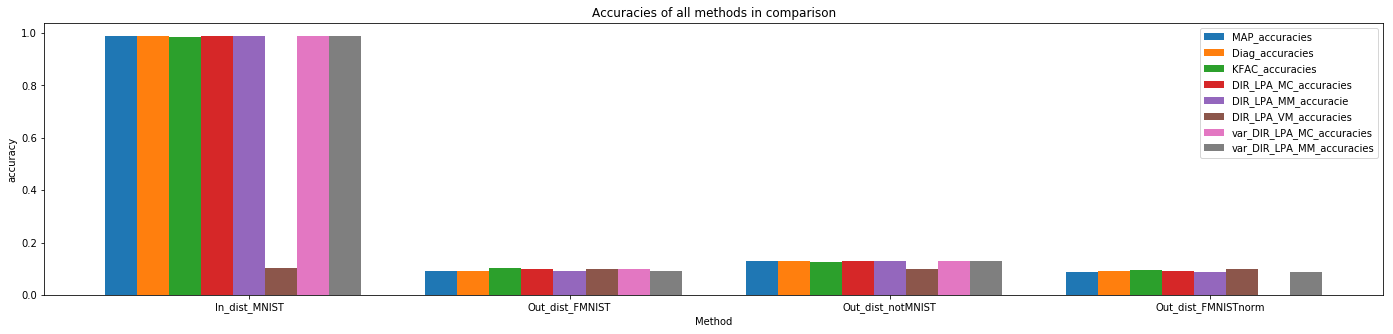

In [230]:
# plot for accuracy
labels=['In_dist_MNIST', 'Out_dist_FMNIST', 'Out_dist_notMNIST', 'Out_dist_FMNISTnorm']
#labels = ['MAP', 'Diag', 'KFAC', 'DIR_LPA_MC', 'DIR_LPA_MM', 'DIR_LPA_VM', 'var_DIR_LPA_MC', 'var_DIR_LPA_MM']
MAP_accuracies = np.array([acc_in_MAP, acc_out_FMNIST_MAP, acc_out_notMNIST_MAP, acc_out_FMNISTn_MAP])
Diag_accuracies = np.array([acc_in_D, acc_out_FMNIST_D, acc_out_notMNIST_D, acc_out_FMNISTn_D])
KFAC_accuracies = np.array([acc_in_KFAC, acc_out_FMNIST_KFAC, acc_out_notMNIST_KFAC, acc_out_FMNISTn_KFAC])
DIR_LPA_MC_accuracies = np.array([acc_in_DIR_LPA_MC, acc_out_FMNIST_DIR_LPA_MC, acc_out_notMNIST_DIR_LPA_MC, acc_out_FMNISTn_DIR_LPA_MC])
DIR_LPA_MM_accuracies = np.array([acc_in_DIR_LPA_MM, acc_out_FMNIST_DIR_LPA_MM, acc_out_notMNIST_DIR_LPA_MM, acc_out_FMNISTn_DIR_LPA_MM])
DIR_LPA_VM_accuracies = np.array([acc_in_DIR_LPA_VM, acc_out_FMNIST_DIR_LPA_VM, acc_out_notMNIST_DIR_LPA_VM, acc_out_FMNISTn_DIR_LPA_VM])
var_DIR_LPA_MC_accuracies = np.array([acc_in_var_DIR_LPA_MC, acc_out_FMNIST_var_DIR_LPA_MC, acc_out_notMNIST_var_DIR_LPA_MC, 0])
var_DIR_LPA_MM_accuracies = np.array([acc_in_var_DIR_LPA_MM, acc_out_FMNIST_var_DIR_LPA_MM, acc_out_notMNIST_var_DIR_LPA_MM, acc_out_FMNISTn_var_DIR_LPA_MM])

X = np.vstack((MAP_accuracies, Diag_accuracies, KFAC_accuracies , DIR_LPA_MC_accuracies, DIR_LPA_MM_accuracies, DIR_LPA_VM_accuracies, var_DIR_LPA_MC_accuracies, var_DIR_LPA_MM_accuracies))
In_dist_accuracies = X[:,0]
Out_dist_accuracies_FMNIST = X[:,1]
Out_dist_accuracies_notMNIST = X[:,2]
Out_dist_accuracies_FMNISTnorm = X[:,3]

width = 0.10  # the width of the bars
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(x - 4*width, MAP_accuracies, width, label='MAP_accuracies')
ax.bar(x - 3*width, Diag_accuracies, width, label='Diag_accuracies')
ax.bar(x - 2*width, KFAC_accuracies, width, label='KFAC_accuracies')
ax.bar(x - 1*width, DIR_LPA_MC_accuracies, width, label='DIR_LPA_MC_accuracies')
ax.bar(x, DIR_LPA_MM_accuracies, width, label='DIR_LPA_MM_accuracie')
ax.bar(x + 1*width, DIR_LPA_VM_accuracies, width, label='DIR_LPA_VM_accuracies')
ax.bar(x + 2*width, var_DIR_LPA_MC_accuracies, width, label='var_DIR_LPA_MC_accuracies')
ax.bar(x + 3*width, var_DIR_LPA_MM_accuracies, width, label='var_DIR_LPA_MM_accuracies')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('accuracy')
plt.title('Accuracies of all methods in comparison')

plt.legend()
#plt.savefig('results_bar_plot.jpg')
#plt.savefig('results_bar_plot.pdf')

plt.show()



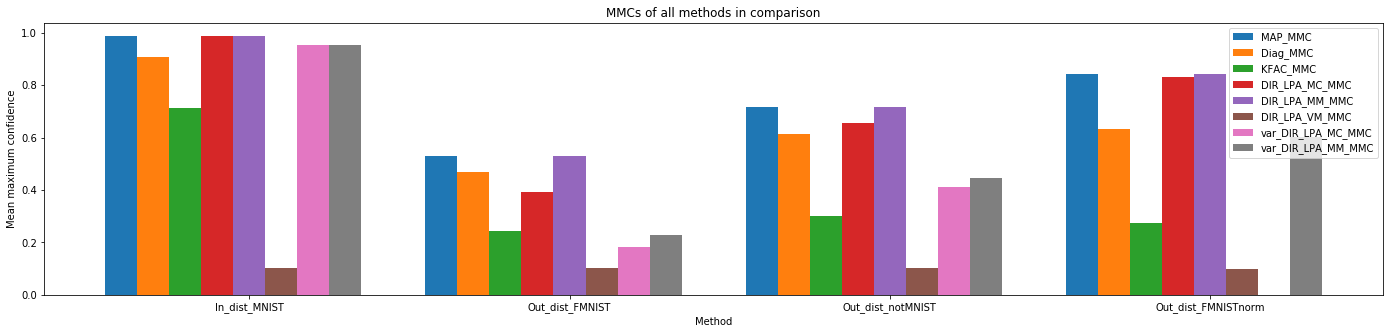

In [232]:
# plot for MMC
labels=['In_dist_MNIST', 'Out_dist_FMNIST', 'Out_dist_notMNIST', 'Out_dist_FMNISTnorm']
#labels = ['MAP', 'Diag', 'KFAC', 'DIR_LPA_MC', 'DIR_LPA_MM', 'DIR_LPA_VM', 'var_DIR_LPA_MC', 'var_DIR_LPA_MM']
MAP_MMC = np.array([MMC_in_MAP, MMC_out_FMNIST_MAP, MMC_out_notMNIST_MAP, MMC_out_FMNISTn_MAP])
Diag_MMC = np.array([MMC_in_D, MMC_out_FMNIST_D, MMC_out_notMNIST_D, MMC_out_FMNISTn_D])
KFAC_MMC = np.array([MMC_in_KFAC, MMC_out_FMNIST_KFAC, MMC_out_notMNIST_KFAC, MMC_out_FMNISTn_KFAC])
DIR_LPA_MC_MMC = np.array([MMC_in_DIR_LPA_MC, MMC_out_FMNIST_DIR_LPA_MC, MMC_out_notMNIST_DIR_LPA_MC, MMC_out_FMNISTn_DIR_LPA_MC])
DIR_LPA_MM_MMC = np.array([MMC_in_DIR_LPA_MM, MMC_out_FMNIST_DIR_LPA_MM, MMC_out_notMNIST_DIR_LPA_MM, MMC_out_FMNISTn_DIR_LPA_MM])
DIR_LPA_VM_MMC = np.array([MMC_in_DIR_LPA_VM, MMC_out_FMNIST_DIR_LPA_VM, MMC_out_notMNIST_DIR_LPA_VM, MMC_out_FMNISTn_DIR_LPA_VM])
var_DIR_LPA_MC_MMC = np.array([MMC_in_var_DIR_LPA_MC, MMC_out_FMNIST_var_DIR_LPA_MC, MMC_out_notMNIST_var_DIR_LPA_MC, 0])
var_DIR_LPA_MM_MMC = np.array([MMC_in_var_DIR_LPA_MM, MMC_out_FMNIST_var_DIR_LPA_MM, MMC_out_notMNIST_var_DIR_LPA_MM, MMC_out_FMNISTn_var_DIR_LPA_MM])

X = np.vstack((MAP_MMC, Diag_MMC, KFAC_MMC , DIR_LPA_MC_MMC, DIR_LPA_MM_MMC, DIR_LPA_VM_MMC, var_DIR_LPA_MC_MMC, var_DIR_LPA_MM_MMC))
In_dist_MMC = X[:,0]
Out_dist_MMC_FMNIST = X[:,1]
Out_dist_MMC_notMNIST = X[:,2]
Out_dist_MMC_FMNISTnorm = X[:,3]

width = 0.10  # the width of the bars
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(x - 4*width, MAP_MMC, width, label='MAP_MMC')
ax.bar(x - 3*width, Diag_MMC, width, label='Diag_MMC')
ax.bar(x - 2*width, KFAC_MMC, width, label='KFAC_MMC')
ax.bar(x - 1*width, DIR_LPA_MC_MMC, width, label='DIR_LPA_MC_MMC')
ax.bar(x, DIR_LPA_MM_MMC, width, label='DIR_LPA_MM_MMC')
ax.bar(x + 1*width, DIR_LPA_VM_MMC, width, label='DIR_LPA_VM_MMC')
ax.bar(x + 2*width, var_DIR_LPA_MC_MMC, width, label='var_DIR_LPA_MC_MMC')
ax.bar(x + 3*width, var_DIR_LPA_MM_MMC, width, label='var_DIR_LPA_MM_MMC')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Mean maximum confidence')
plt.title('MMCs of all methods in comparison')

plt.legend()
#plt.savefig('results_bar_plot.jpg')
#plt.savefig('results_bar_plot.pdf')

plt.show()



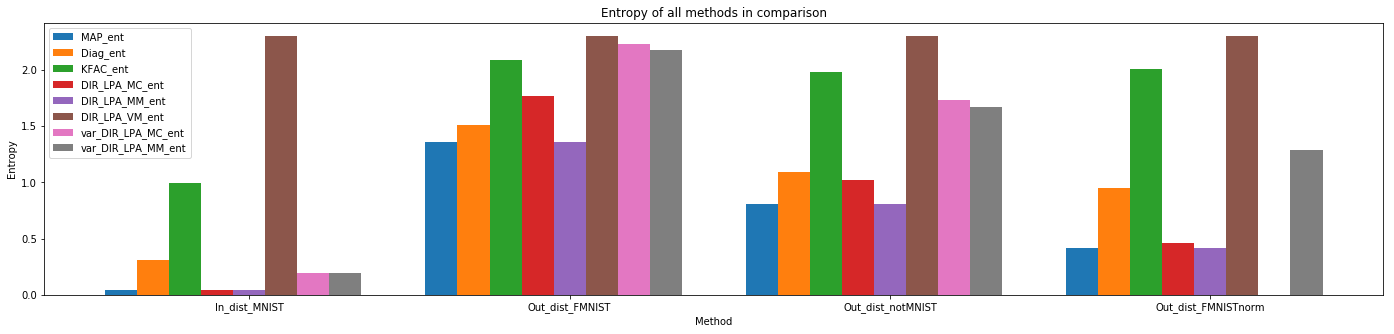

In [233]:
# plot for entropy
labels=['In_dist_MNIST', 'Out_dist_FMNIST', 'Out_dist_notMNIST', 'Out_dist_FMNISTnorm']
#labels = ['MAP', 'Diag', 'KFAC', 'DIR_LPA_MC', 'DIR_LPA_MM', 'DIR_LPA_VM', 'var_DIR_LPA_MC', 'var_DIR_LPA_MM']
MAP_ent = np.array([ent_in_MAP, ent_out_FMNIST_MAP, ent_out_notMNIST_MAP, ent_out_FMNISTn_MAP])
Diag_ent = np.array([ent_in_D, ent_out_FMNIST_D, ent_out_notMNIST_D, ent_out_FMNISTn_D])
KFAC_ent = np.array([ent_in_KFAC, ent_out_FMNIST_KFAC, ent_out_notMNIST_KFAC, ent_out_FMNISTn_KFAC])
DIR_LPA_MC_ent = np.array([ent_in_DIR_LPA_MC, ent_out_FMNIST_DIR_LPA_MC, ent_out_notMNIST_DIR_LPA_MC, ent_out_FMNISTn_DIR_LPA_MC])
DIR_LPA_MM_ent = np.array([ent_in_DIR_LPA_MM, ent_out_FMNIST_DIR_LPA_MM, ent_out_notMNIST_DIR_LPA_MM, ent_out_FMNISTn_DIR_LPA_MM])
DIR_LPA_VM_ent = np.array([ent_in_DIR_LPA_VM, ent_out_FMNIST_DIR_LPA_VM, ent_out_notMNIST_DIR_LPA_VM, ent_out_FMNISTn_DIR_LPA_VM])
var_DIR_LPA_MC_ent = np.array([ent_in_var_DIR_LPA_MC, ent_out_FMNIST_var_DIR_LPA_MC, ent_out_notMNIST_var_DIR_LPA_MC, 0])
var_DIR_LPA_MM_ent = np.array([ent_in_var_DIR_LPA_MM, ent_out_FMNIST_var_DIR_LPA_MM, ent_out_notMNIST_var_DIR_LPA_MM, ent_out_FMNISTn_var_DIR_LPA_MM])

X = np.vstack((MAP_ent, Diag_ent, KFAC_ent , DIR_LPA_MC_ent, DIR_LPA_MM_ent, DIR_LPA_VM_ent, var_DIR_LPA_MC_ent, var_DIR_LPA_MM_ent))
In_dist_ent = X[:,0]
Out_dist_ent_FMNIST = X[:,1]
Out_dist_ent_notMNIST = X[:,2]
Out_dist_ent_FMNISTnorm = X[:,3]

width = 0.10  # the width of the bars
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(x - 4*width, MAP_ent, width, label='MAP_ent')
ax.bar(x - 3*width, Diag_ent, width, label='Diag_ent')
ax.bar(x - 2*width, KFAC_ent, width, label='KFAC_ent')
ax.bar(x - 1*width, DIR_LPA_MC_ent, width, label='DIR_LPA_MC_ent')
ax.bar(x, DIR_LPA_MM_ent, width, label='DIR_LPA_MM_ent')
ax.bar(x + 1*width, DIR_LPA_VM_ent, width, label='DIR_LPA_VM_ent')
ax.bar(x + 2*width, var_DIR_LPA_MC_ent, width, label='var_DIR_LPA_MC_ent')
ax.bar(x + 3*width, var_DIR_LPA_MM_ent, width, label='var_DIR_LPA_MM_ent')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Entropy')
plt.title('Entropy of all methods in comparison')

plt.legend()
#plt.savefig('results_bar_plot.jpg')
#plt.savefig('results_bar_plot.pdf')

plt.show()



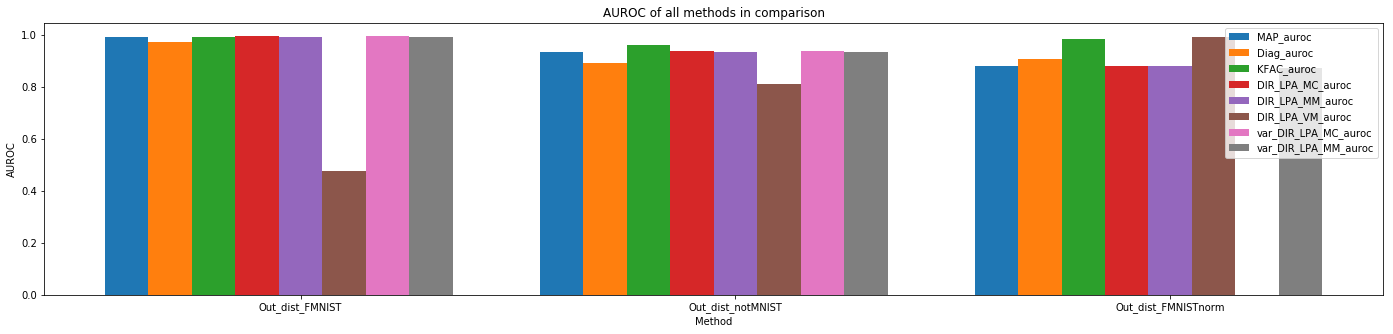

In [235]:
# plot for auroc
labels=['Out_dist_FMNIST', 'Out_dist_notMNIST', 'Out_dist_FMNISTnorm']
#labels = ['MAP', 'Diag', 'KFAC', 'DIR_LPA_MC', 'DIR_LPA_MM', 'DIR_LPA_VM', 'var_DIR_LPA_MC', 'var_DIR_LPA_MM']
MAP_auroc = np.array([auroc_out_FMNIST_MAP, auroc_out_notMNIST_MAP, auroc_out_FMNISTn_MAP])
Diag_auroc = np.array([auroc_out_FMNIST_D, auroc_out_notMNIST_D, auroc_out_FMNISTn_D])
KFAC_auroc = np.array([auroc_out_FMNIST_KFAC, auroc_out_notMNIST_KFAC, auroc_out_FMNISTn_KFAC])
DIR_LPA_MC_auroc = np.array([auroc_out_FMNIST_DIR_LPA_MC, auroc_out_notMNIST_DIR_LPA_MC, auroc_out_FMNISTn_DIR_LPA_MC])
DIR_LPA_MM_auroc = np.array([auroc_out_FMNIST_DIR_LPA_MM, auroc_out_notMNIST_DIR_LPA_MM, auroc_out_FMNISTn_DIR_LPA_MM])
DIR_LPA_VM_auroc = np.array([auroc_out_FMNIST_DIR_LPA_VM, auroc_out_notMNIST_DIR_LPA_VM, auroc_out_FMNISTn_DIR_LPA_VM])
var_DIR_LPA_MC_auroc = np.array([auroc_out_FMNIST_var_DIR_LPA_MC, auroc_out_notMNIST_var_DIR_LPA_MC, 0])
var_DIR_LPA_MM_auroc = np.array([auroc_out_FMNIST_var_DIR_LPA_MM, auroc_out_notMNIST_var_DIR_LPA_MM, auroc_out_FMNISTn_var_DIR_LPA_MM])

X = np.vstack((MAP_auroc, Diag_auroc, KFAC_auroc , DIR_LPA_MC_auroc, DIR_LPA_MM_auroc, DIR_LPA_VM_auroc, var_DIR_LPA_MC_auroc, var_DIR_LPA_MM_auroc))
Out_dist_ent_FMNIST = X[:,0]
Out_dist_ent_notMNIST = X[:,1]
Out_dist_ent_FMNISTnorm = X[:,2]

width = 0.10  # the width of the bars
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(x - 4*width, MAP_auroc, width, label='MAP_auroc')
ax.bar(x - 3*width, Diag_auroc, width, label='Diag_auroc')
ax.bar(x - 2*width, KFAC_auroc, width, label='KFAC_auroc')
ax.bar(x - 1*width, DIR_LPA_MC_auroc, width, label='DIR_LPA_MC_auroc')
ax.bar(x, DIR_LPA_MM_auroc, width, label='DIR_LPA_MM_auroc')
ax.bar(x + 1*width, DIR_LPA_VM_auroc, width, label='DIR_LPA_VM_auroc')
ax.bar(x + 2*width, var_DIR_LPA_MC_auroc, width, label='var_DIR_LPA_MC_auroc')
ax.bar(x + 3*width, var_DIR_LPA_MM_auroc, width, label='var_DIR_LPA_MM_auroc')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('AUROC')
plt.title('AUROC of all methods in comparison')

plt.legend()
#plt.savefig('results_bar_plot.jpg')
#plt.savefig('results_bar_plot.pdf')

plt.show()



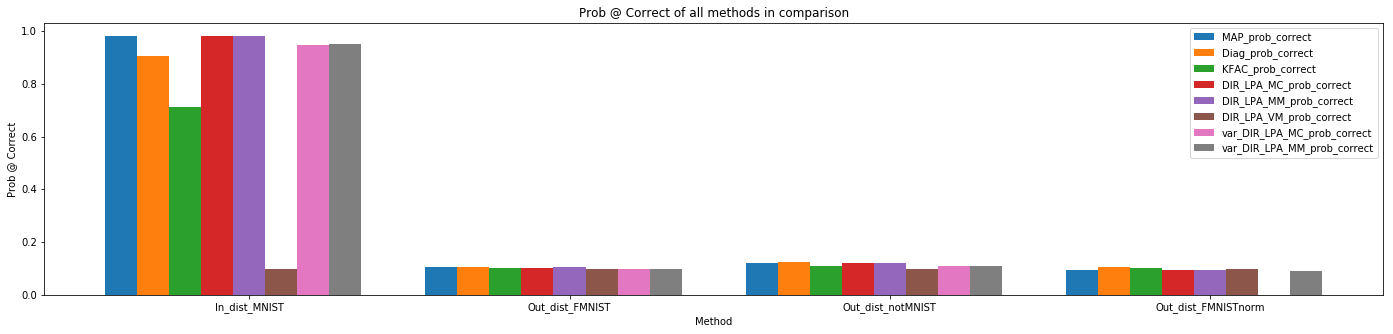

In [236]:
# plot for prob @ correct
labels=['In_dist_MNIST', 'Out_dist_FMNIST', 'Out_dist_notMNIST', 'Out_dist_FMNISTnorm']
#labels = ['MAP', 'Diag', 'KFAC', 'DIR_LPA_MC', 'DIR_LPA_MM', 'DIR_LPA_VM', 'var_DIR_LPA_MC', 'var_DIR_LPA_MM']
MAP_prob_correct = np.array([prob_correct_in_MAP, prob_correct_out_FMNIST_MAP, prob_correct_out_notMNIST_MAP, prob_correct_out_FMNISTn_MAP])
Diag_prob_correct = np.array([prob_correct_in_D, prob_correct_out_FMNIST_D, prob_correct_out_notMNIST_D, prob_correct_out_FMNISTn_D])
KFAC_prob_correct = np.array([prob_correct_in_KFAC, prob_correct_out_FMNIST_KFAC, prob_correct_out_notMNIST_KFAC, prob_correct_out_FMNISTn_KFAC])
DIR_LPA_MC_prob_correct = np.array([prob_correct_in_DIR_LPA_MC, prob_correct_out_FMNIST_DIR_LPA_MC, prob_correct_out_notMNIST_DIR_LPA_MC, prob_correct_out_FMNISTn_DIR_LPA_MC])
DIR_LPA_MM_prob_correct = np.array([prob_correct_in_DIR_LPA_MM, prob_correct_out_FMNIST_DIR_LPA_MM, prob_correct_out_notMNIST_DIR_LPA_MM, prob_correct_out_FMNISTn_DIR_LPA_MM])
DIR_LPA_VM_prob_correct = np.array([prob_correct_in_DIR_LPA_VM, prob_correct_out_FMNIST_DIR_LPA_VM, prob_correct_out_notMNIST_DIR_LPA_VM, prob_correct_out_FMNISTn_DIR_LPA_VM])
var_DIR_LPA_MC_prob_correct = np.array([prob_correct_in_var_DIR_LPA_MC, prob_correct_out_FMNIST_var_DIR_LPA_MC, prob_correct_out_notMNIST_var_DIR_LPA_MC, 0])
var_DIR_LPA_MM_prob_correct = np.array([prob_correct_in_var_DIR_LPA_MM, prob_correct_out_FMNIST_var_DIR_LPA_MM, prob_correct_out_notMNIST_var_DIR_LPA_MM, prob_correct_out_FMNISTn_var_DIR_LPA_MM])

X = np.vstack((MAP_prob_correct, Diag_prob_correct, KFAC_prob_correct , DIR_LPA_MC_prob_correct, DIR_LPA_MM_prob_correct, DIR_LPA_VM_prob_correct, var_DIR_LPA_MC_prob_correct, var_DIR_LPA_MM_prob_correct))
In_dist_prob_correct = X[:,0]
Out_dist_prob_correct_FMNIST = X[:,1]
Out_dist_prob_correct_notMNIST = X[:,2]
Out_dist_prob_correct_FMNISTnorm = X[:,3]

width = 0.10  # the width of the bars
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(x - 4*width, MAP_prob_correct, width, label='MAP_prob_correct')
ax.bar(x - 3*width, Diag_prob_correct, width, label='Diag_prob_correct')
ax.bar(x - 2*width, KFAC_prob_correct, width, label='KFAC_prob_correct')
ax.bar(x - 1*width, DIR_LPA_MC_prob_correct, width, label='DIR_LPA_MC_prob_correct')
ax.bar(x, DIR_LPA_MM_prob_correct, width, label='DIR_LPA_MM_prob_correct')
ax.bar(x + 1*width, DIR_LPA_VM_prob_correct, width, label='DIR_LPA_VM_prob_correct')
ax.bar(x + 2*width, var_DIR_LPA_MC_prob_correct, width, label='var_DIR_LPA_MC_prob_correct')
ax.bar(x + 3*width, var_DIR_LPA_MM_prob_correct, width, label='var_DIR_LPA_MM_prob_correct')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Prob @ Correct')
plt.title('Prob @ Correct of all methods in comparison')

plt.legend()
#plt.savefig('results_bar_plot.jpg')
#plt.savefig('results_bar_plot.pdf')

plt.show()



# check out the scaled dirichlet

In [289]:
from scipy.special import digamma
#define all the functions

#define closure function
def pertubation(a,b):
    return(a*b)

def closure(x, k=1):
    return(k*x/x.sum())

def inverse_closure(x):
    inv = 1/(x + 10e-8)
    return(inv/inv.sum())

def dirichlet_mode_a(alpha):
    return(closure(alpha))

def dirichlet_expected_a(alpha):
    return(closure(np.exp(digamma(alpha))))

def scaled_dirichlet_mode_a(alpha, beta):
    return(closure(pertubation(inverse_closure(beta), dirichlet_mode_a(alpha))))
    
def scaled_dirichlet_expected_a(alpha, beta):
    return(closure(pertubation(inverse_closure(beta), dirichlet_expected_a(alpha))))

def scaled_dirichlet_mode_a_batch(alpha, beta):
    r = []
    for i in range(len(alpha)):
        r.append(scaled_dirichlet_mode_a(alpha[i], beta[i]))
        
    return(torch.stack(r).numpy())

def scaled_dirichlet_expected_a_batch(alpha, beta):
    r = []
    for i in range(len(alpha)):
        r.append(scaled_dirichlet_expected_a(alpha[i], beta[i]))
        
    return(torch.stack(r).numpy())

test_a = np.array(range(1,6))
test_b = np.array(range(5, 10))
test_p = pertubation(test_a, test_b)
test_c = closure(test_p)
test_inv_c = inverse_closure(test_c)
test_c2 = closure(test_inv_c)
           
test_mode_a = dirichlet_mode_a(test_a)
test_scaled_mode_a = scaled_dirichlet_mode_a(test_a, test_b)
test_E_a = dirichlet_expected_a(test_a)
test_scaled_E_a = scaled_dirichlet_expected_a(test_a, test_b)
print(test_p)
print(test_c)
print(test_inv_c)
print(test_c2)
print(test_mode_a)
print(test_scaled_mode_a)
print(test_E_a)
print(test_scaled_E_a)


[ 5 12 21 32 45]
[0.04347826 0.10434783 0.1826087  0.27826087 0.39130435]
[0.52025766 0.21677431 0.12387109 0.08129042 0.05780652]
[0.52025766 0.21677431 0.12387109 0.08129042 0.05780652]
[0.06666667 0.13333333 0.2        0.26666667 0.33333333]
[0.09913454 0.16522423 0.21243116 0.24783635 0.27537372]
[0.04447238 0.12088846 0.19931138 0.27816143 0.35716635]
[0.06739723 0.15267056 0.21575246 0.26346846 0.30071129]


In [299]:
# test on data
#McKay
alphas_var_mnist_in_DIR_LPA_MC = torch.Tensor(alphas_variance(mnist_test_in_DIR_LPA_MC))
alphas_var_out_FMNIST_DIR_LPA_MC = torch.Tensor(alphas_variance(mnist_test_out_FMNIST_DIR_LPA_MC))
alphas_var_out_notMNIST_DIR_LPA_MC = torch.Tensor(alphas_variance(mnist_test_out_notMNIST_DIR_LPA_MC))
alphas_var_out_FMNIST_normalized_DIR_LPA_MC = torch.Tensor(alphas_variance(mnist_test_out_FMNIST_normalized_DIR_LPA_MC))

in_mnist_test_scaled_MC = scaled_dirichlet_expected_a_batch(torch.Tensor(mnist_test_in_DIR_LPA_MC), alphas_var_mnist_in_DIR_LPA_MC)
out_FMNIST_test_scaled_MC = scaled_dirichlet_expected_a_batch(torch.Tensor(mnist_test_out_FMNIST_DIR_LPA_MC), alphas_var_out_FMNIST_DIR_LPA_MC)
out_notMNIST_test_scaled_MC = scaled_dirichlet_expected_a_batch(torch.Tensor(mnist_test_out_notMNIST_DIR_LPA_MC), alphas_var_out_notMNIST_DIR_LPA_MC)
out_FMNIST_normalized_test_scaled_MC = scaled_dirichlet_expected_a_batch(torch.Tensor(mnist_test_out_FMNIST_normalized_DIR_LPA_MC), alphas_var_out_FMNIST_normalized_DIR_LPA_MC)

in_mnist_test_scaled_mode_MC = scaled_dirichlet_mode_a_batch(torch.Tensor(mnist_test_in_DIR_LPA_MC), alphas_var_mnist_in_DIR_LPA_MC)
out_FMNIST_test_scaled_mode_MC = scaled_dirichlet_mode_a_batch(torch.Tensor(mnist_test_out_FMNIST_DIR_LPA_MC), alphas_var_out_FMNIST_DIR_LPA_MC)
out_notMNIST_test_scaled_mode_MC = scaled_dirichlet_mode_a_batch(torch.Tensor(mnist_test_out_notMNIST_DIR_LPA_MC), alphas_var_out_notMNIST_DIR_LPA_MC)
out_FMNIST_normalized_test_scaled_mode_MC = scaled_dirichlet_mode_a_batch(torch.Tensor(mnist_test_out_FMNIST_normalized_DIR_LPA_MC), alphas_var_out_FMNIST_normalized_DIR_LPA_MC)
#MAP match
in_mnist_test_scaled_MM = get_norm_variance_alphas(mnist_test_in_DIR_LPA_MM)
out_FMNIST_test_scaled_MM = get_norm_variance_alphas(mnist_test_out_FMNIST_DIR_LPA_MM)
out_notMNIST_test_scaled_MM = get_norm_variance_alphas(mnist_test_out_notMNIST_DIR_LPA_MM)
out_FMNIST_normalized_test_scaled_MM = get_norm_variance_alphas(mnist_test_out_FMNIST_normalized_DIR_LPA_MM)

In [300]:
acc_in_var_DIR_LPA_MC, prob_correct_in_var_DIR_LPA_MC, ent_in_var_DIR_LPA_MC, MMC_in_var_DIR_LPA_MC = get_in_dist_values(in_mnist_test_scaled_MC, targets)
acc_out_FMNIST_var_DIR_LPA_MC, prob_correct_out_FMNIST_var_DIR_LPA_MC, ent_out_FMNIST_var_DIR_LPA_MC, MMC_out_FMNIST_var_DIR_LPA_MC, auroc_out_FMNIST_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_scaled_MC, out_FMNIST_test_scaled_MC, targets_FMNIST)
acc_out_notMNIST_var_DIR_LPA_MC, prob_correct_out_notMNIST_var_DIR_LPA_MC, ent_out_notMNIST_var_DIR_LPA_MC, MMC_out_notMNIST_var_DIR_LPA_MC, auroc_out_notMNIST_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_scaled_MC, out_notMNIST_test_scaled_MC, targets_notMNIST)
acc_out_FMNISTn_var_DIR_LPA_MC, prob_correct_out_FMNISTn_var_DIR_LPA_MC, ent_out_FMNISTn_var_DIR_LPA_MC, MMC_out_FMNISTn_var_DIR_LPA_MC, auroc_out_FMNISTn_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_scaled_MC, out_FMNIST_normalized_test_scaled_MC, targets_FMNIST_normalized)
print_in_dist_values(acc_in_var_DIR_LPA_MC, prob_correct_in_var_DIR_LPA_MC, ent_in_var_DIR_LPA_MC, MMC_in_var_DIR_LPA_MC, 'mnist', 'var_DIR_LPA_MC')
print_out_dist_values(acc_out_FMNIST_var_DIR_LPA_MC, prob_correct_out_FMNIST_var_DIR_LPA_MC, ent_out_FMNIST_var_DIR_LPA_MC, MMC_out_FMNIST_var_DIR_LPA_MC, auroc_out_FMNIST_var_DIR_LPA_MC, test='fmnist', method='var_DIR_LPA_MC')
print_out_dist_values(acc_out_notMNIST_var_DIR_LPA_MC, prob_correct_out_notMNIST_var_DIR_LPA_MC, ent_out_notMNIST_var_DIR_LPA_MC, MMC_out_notMNIST_var_DIR_LPA_MC, auroc_out_notMNIST_var_DIR_LPA_MC, test='notMNIST', method='var_DIR_LPA_MC')
print_out_dist_values(acc_out_FMNISTn_var_DIR_LPA_MC, prob_correct_out_FMNISTn_var_DIR_LPA_MC, ent_out_FMNISTn_var_DIR_LPA_MC, MMC_out_FMNISTn_var_DIR_LPA_MC, auroc_out_FMNISTn_var_DIR_LPA_MC, test='FMNISTn', method='var_DIR_LPA_MC')

[In, var_DIR_LPA_MC, mnist] Accuracy: 0.989; average entropy: 0.056;     MMC: 0.983; Prob @ correct: 0.977
[Out-fmnist, var_DIR_LPA_MC, mnist] Accuracy: 0.100; Average entropy: 0.599;    MMC: 0.781; AUROC: 0.907; Prob @ correct: 0.108
[Out-notMNIST, var_DIR_LPA_MC, mnist] Accuracy: 0.131; Average entropy: 0.450;    MMC: 0.827; AUROC: 0.827; Prob @ correct: 0.130
[Out-FMNISTn, var_DIR_LPA_MC, mnist] Accuracy: 0.089; Average entropy: 0.421;    MMC: 0.838; AUROC: 0.848; Prob @ correct: 0.094


In [301]:
acc_in_var_DIR_LPA_MC, prob_correct_in_var_DIR_LPA_MC, ent_in_var_DIR_LPA_MC, MMC_in_var_DIR_LPA_MC = get_in_dist_values(in_mnist_test_scaled_mode_MC, targets)
acc_out_FMNIST_var_DIR_LPA_MC, prob_correct_out_FMNIST_var_DIR_LPA_MC, ent_out_FMNIST_var_DIR_LPA_MC, MMC_out_FMNIST_var_DIR_LPA_MC, auroc_out_FMNIST_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_scaled_mode_MC, out_FMNIST_test_scaled_mode_MC, targets_FMNIST)
acc_out_notMNIST_var_DIR_LPA_MC, prob_correct_out_notMNIST_var_DIR_LPA_MC, ent_out_notMNIST_var_DIR_LPA_MC, MMC_out_notMNIST_var_DIR_LPA_MC, auroc_out_notMNIST_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_scaled_mode_MC, out_notMNIST_test_scaled_mode_MC, targets_notMNIST)
acc_out_FMNISTn_var_DIR_LPA_MC, prob_correct_out_FMNISTn_var_DIR_LPA_MC, ent_out_FMNISTn_var_DIR_LPA_MC, MMC_out_FMNISTn_var_DIR_LPA_MC, auroc_out_FMNISTn_var_DIR_LPA_MC = get_out_dist_values(in_mnist_test_scaled_mode_MC, out_FMNIST_normalized_test_scaled_mode_MC, targets_FMNIST_normalized)
print_in_dist_values(acc_in_var_DIR_LPA_MC, prob_correct_in_var_DIR_LPA_MC, ent_in_var_DIR_LPA_MC, MMC_in_var_DIR_LPA_MC, 'mnist', 'var_DIR_LPA_MC')
print_out_dist_values(acc_out_FMNIST_var_DIR_LPA_MC, prob_correct_out_FMNIST_var_DIR_LPA_MC, ent_out_FMNIST_var_DIR_LPA_MC, MMC_out_FMNIST_var_DIR_LPA_MC, auroc_out_FMNIST_var_DIR_LPA_MC, test='fmnist', method='var_DIR_LPA_MC')
print_out_dist_values(acc_out_notMNIST_var_DIR_LPA_MC, prob_correct_out_notMNIST_var_DIR_LPA_MC, ent_out_notMNIST_var_DIR_LPA_MC, MMC_out_notMNIST_var_DIR_LPA_MC, auroc_out_notMNIST_var_DIR_LPA_MC, test='notMNIST', method='var_DIR_LPA_MC')
print_out_dist_values(acc_out_FMNISTn_var_DIR_LPA_MC, prob_correct_out_FMNISTn_var_DIR_LPA_MC, ent_out_FMNISTn_var_DIR_LPA_MC, MMC_out_FMNISTn_var_DIR_LPA_MC, auroc_out_FMNISTn_var_DIR_LPA_MC, test='FMNISTn', method='var_DIR_LPA_MC')

[In, var_DIR_LPA_MC, mnist] Accuracy: 0.989; average entropy: 0.107;     MMC: 0.971; Prob @ correct: 0.966
[Out-fmnist, var_DIR_LPA_MC, mnist] Accuracy: 0.100; Average entropy: 2.227;    MMC: 0.182; AUROC: 0.997; Prob @ correct: 0.098
[Out-notMNIST, var_DIR_LPA_MC, mnist] Accuracy: 0.131; Average entropy: 1.702;    MMC: 0.420; AUROC: 0.948; Prob @ correct: 0.109
[Out-FMNISTn, var_DIR_LPA_MC, mnist] Accuracy: 0.089; Average entropy: 0.978;    MMC: 0.678; AUROC: 0.873; Prob @ correct: 0.094


In [ ]:
[In, var_DIR_LPA_MC, mnist] Accuracy: 0.989; average entropy: 0.196;     MMC: 0.952; Prob @ correct: 0.948
[Out-fmnist, var_DIR_LPA_MC, mnist] Accuracy: 0.100; Average entropy: 2.228;    MMC: 0.182; AUROC: 0.994; Prob @ correct: 0.098
[Out-notMNIST, var_DIR_LPA_MC, mnist] Accuracy: 0.131; Average entropy: 1.729;    MMC: 0.413; AUROC: 0.938; Prob @ correct: 0.109

In [39]:
num units in last hidden layer = 250

[In, LLLA-KF, mnist] Accuracy: 0.989; average entropy: 0.041; MMC: 0.988
[Out-FMNIST, MAP, mnist] Average entropy: 1.363; MMC: 0.531; AUROC: 0.991
[Out-notMNIST, MAP, mnist] Average entropy: 0.806; MMC: 0.718; AUROC: 0.934
[Out-normalized FMNIST, MAP, mnist] Average entropy: 0.421; MMC: 0.841; AUROC: 0.880
            
[In, LLLA-KF, mnist] Accuracy: 0.988; average entropy: 0.309; MMC: 0.909
[Out-FMNIST, Diag, mnist] Average entropy: 1.514; MMC: 0.470; AUROC: 0.972
[Out-notMNIST, Diag, mnist] Average entropy: 1.094; MMC: 0.613; AUROC: 0.890
[Out-normalized FMNIST, Diag, mnist] Average entropy: 0.955; MMC: 0.634; AUROC: 0.908
            
[In, LLLA-KF, mnist] Accuracy: 0.986; average entropy: 0.975; MMC: 0.720
[Out-FMNIST, KFAC, mnist] Average entropy: 2.081; MMC: 0.246; AUROC: 0.991
[Out-notMNIST, KFAC, mnist] Average entropy: 1.979; MMC: 0.302; AUROC: 0.961
[Out-normalized FMNIST, KFAC, mnist] Average entropy: 2.008; MMC: 0.275; AUROC: 0.984
            
[In, LLLA-KF, mnist] Accuracy: 0.989; average entropy: 0.043; MMC: 0.987
[Out-FMNIST, DIR_LPA, mnist] Average entropy: 1.774; MMC: 0.392; AUROC: 0.995
[Out-notMNIST, DIR_LPA, mnist] Average entropy: 1.022; MMC: 0.657; AUROC: 0.938
[Out-normalized FMNIST, DIR_LPA, mnist] Average entropy: 0.462; MMC: 0.832; AUROC: 0.878
            
[In, LLLA-KF, mnist] Accuracy: 0.987; average entropy: 0.048; MMC: 0.986
[Out-FMNIST, DIR_LPA, mnist] Average entropy: 1.849; MMC: 0.347; AUROC: 0.996
[Out-notMNIST, DIR_LPA, mnist] Average entropy: 1.113; MMC: 0.627; AUROC: 0.949
[Out-normalized FMNIST, DIR_LPA, mnist] Average entropy: 0.516; MMC: 0.815; AUROC: 0.889
            
[In, LLLA-KF, mnist] Accuracy: 0.989; average entropy: 0.191; MMC: 0.953
[Out-FMNIST, DIR_LPA, mnist] Average entropy: 2.181; MMC: 0.227; AUROC: 0.991
[Out-notMNIST, DIR_LPA, mnist] Average entropy: 1.673; MMC: 0.447; AUROC: 0.934
[Out-normalized FMNIST, DIR_LPA, mnist] Average entropy: 1.288; MMC: 0.602; AUROC: 0.873

            

SyntaxError: invalid syntax (<ipython-input-39-545770523ba2>, line 1)